In [251]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.ensemble import (GradientBoostingRegressor, 
                              GradientBoostingClassifier, 
                              AdaBoostClassifier,
                              RandomForestClassifier)

from sklearn.inspection import partial_dependence

import sklearn.model_selection as cv
from sklearn.model_selection import KFold, RandomizedSearchCV, GridSearchCV
from sklearn.inspection import plot_partial_dependence

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## *EDA*

In [252]:
# Load dataframe containing individual games

game_df = pd.read_csv('data/game.csv')
game_df.head()
game_df

,game_id,season,type,date_time,date_time_GMT,away_team_id,home_team_id,away_goals,home_goals,outcome,home_rink_side_start,venue,venue_link,venue_time_zone_id,venue_time_zone_offset,venue_time_zone_tz
0,2011030221,20112012,P,2012-04-29,2012-04-29T19:00:00Z,1,4,3,4,home win OT,right,Wells Fargo Center,/api/v1/venues/null,America/New_York,-4,EDT
1,2011030222,20112012,P,2012-05-01,2012-05-01T23:30:00Z,1,4,4,1,away win REG,right,Wells Fargo Center,/api/v1/venues/null,America/New_York,-4,EDT
2,2011030223,20112012,P,2012-05-03,2012-05-03T23:30:00Z,4,1,3,4,home win OT,left,Prudential Center,/api/v1/venues/null,America/New_York,-4,EDT
3,2011030224,20112012,P,2012-05-06,2012-05-06T23:30:00Z,4,1,2,4,home win REG,left,Prudential Center,/api/v1/venues/null,America/New_York,-4,EDT
4,2011030225,20112012,P,2012-05-08,2012-05-08T23:30:00Z,1,4,3,1,away win REG,right,Wells Fargo Center,/api/v1/venues/null,America/New_York,-4,EDT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11429,2018030413,20182019,P,2019-06-02,2019-06-02T00:00:00Z,6,19,7,2,away win REG,left,Enterprise Center,/api/v1/venues/5076,America/Chicago,-5,CDT
11430,2018030414,20182019,P,2019-06-04,2019-06-04T00:00:00Z,6,19,2,4,home win REG,left,Enterprise Center,/api/v1/venues/5076,America/Chicago,-5,CDT
11431,2018030415,20182019,P,2019-06-07,2019-06-07T00:00:00Z,19,6,2,1,away win REG,left,TD Garden,/api/v1/venues/5085,America/New_York,-4,EDT
11432,2018030416,20182019,P,2019-06-10,2019-06-10T00:00:00Z,6,19,5,1,away win REG,left,Enterprise Center,/api/v1/venues/5076,America/Chicago,-5,CDT


In [253]:
game_df['goal_spread'] = abs(game_df['away_goals'] - game_df['home_goals'])

In [254]:
# average goal spread
game_df['goal_spread'].mean()

2.0534371173692496

In [255]:
game_df['total_goals'] = game_df['away_goals'] + game_df['home_goals']

In [256]:
game_df['total_goals'].mean()

5.5885079587196085

In [257]:
# Adjust win/loss column based on home team

game_df.loc[game_df['outcome'].str.contains('home'), 'outcome'] = 'win'
game_df.loc[game_df['outcome'].str.contains('away'), 'outcome'] = 'loss'

In [258]:
# Load dataframe containing team info
# This might be useful for finding out specific team names but won't be used for now.

team_df = pd.read_csv('data/team_info.csv')
team_df.head(6)

,team_id,franchiseId,shortName,teamName,abbreviation,link
0,1,23,New Jersey,Devils,NJD,/api/v1/teams/1
1,4,16,Philadelphia,Flyers,PHI,/api/v1/teams/4
2,26,14,Los Angeles,Kings,LAK,/api/v1/teams/26
3,14,31,Tampa Bay,Lightning,TBL,/api/v1/teams/14
4,6,6,Boston,Bruins,BOS,/api/v1/teams/6
5,3,10,NY Rangers,Rangers,NYR,/api/v1/teams/3


In [259]:
team_df[team_df['team_id'] == 5]

,team_id,franchiseId,shortName,teamName,abbreviation,link
6,5,17,Pittsburgh,Penguins,PIT,/api/v1/teams/5


* The dataframe below will be used to compile cumulative statistics as a season progresses.

In [260]:
# Load dataframe of game outcomes grouped by teams
# Each row is one game for one team.

team_game_df = pd.read_csv('data/game_teams_stats.csv')
team_game_df.loc[team_game_df.team_id == 1]

,game_id,team_id,HoA,won,settled_in,head_coach,goals,shots,hits,pim,powerPlayOpportunities,powerPlayGoals,faceOffWinPercentage,giveaways,takeaways
0,2011030221,1,away,False,OT,Peter DeBoer,3,26,31,12,3,1,44.9,6,7
2,2011030222,1,away,True,REG,Peter DeBoer,4,35,32,12,4,0,50.9,8,7
5,2011030223,1,home,True,OT,Peter DeBoer,4,31,30,10,2,1,49.2,11,4
7,2011030224,1,home,True,REG,Peter DeBoer,4,43,19,4,5,1,37.5,5,3
8,2011030225,1,away,True,REG,Peter DeBoer,3,30,26,2,4,1,55.0,6,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22548,2018021199,1,away,False,REG,John Hynes,0,28,44,2,1,0,47.1,13,5
22567,2018021207,1,home,False,OT,John Hynes,2,27,20,2,3,1,47.8,11,10
22595,2018021222,1,home,True,REG,John Hynes,4,41,23,21,4,1,66.7,10,5
22644,2018021247,1,away,False,REG,John Hynes,1,37,30,4,3,0,50.0,7,10


In [261]:
# Create column showing previous game's outcome

team_game_df['streak'] = team_game_df.groupby('team_id')['won'].shift(fill_value=0)
team_game_df.head()

,game_id,team_id,HoA,won,settled_in,head_coach,goals,shots,hits,pim,powerPlayOpportunities,powerPlayGoals,faceOffWinPercentage,giveaways,takeaways,streak
0,2011030221,1,away,False,OT,Peter DeBoer,3,26,31,12,3,1,44.9,6,7,0
1,2011030221,4,home,True,OT,Peter Laviolette,4,36,27,6,6,1,55.1,13,4,0
2,2011030222,1,away,True,REG,Peter DeBoer,4,35,32,12,4,0,50.9,8,7,False
3,2011030222,4,home,False,REG,Peter Laviolette,1,20,24,32,5,0,49.1,9,6,True
4,2011030223,4,away,False,OT,Peter Laviolette,3,28,28,4,5,1,50.8,2,1,False


In [262]:
# Replace 0s in the 'streak' column with False due a team not having a previous game in the dataset

team_game_df = team_game_df.replace({'streak': 0}, False)
team_game_df.head()

,game_id,team_id,HoA,won,settled_in,head_coach,goals,shots,hits,pim,powerPlayOpportunities,powerPlayGoals,faceOffWinPercentage,giveaways,takeaways,streak
0,2011030221,1,away,False,OT,Peter DeBoer,3,26,31,12,3,1,44.9,6,7,False
1,2011030221,4,home,True,OT,Peter Laviolette,4,36,27,6,6,1,55.1,13,4,False
2,2011030222,1,away,True,REG,Peter DeBoer,4,35,32,12,4,0,50.9,8,7,False
3,2011030222,4,home,False,REG,Peter Laviolette,1,20,24,32,5,0,49.1,9,6,True
4,2011030223,4,away,False,OT,Peter Laviolette,3,28,28,4,5,1,50.8,2,1,False


In [263]:
# Merge game dataframe to pull timezone data

df = pd.merge(team_game_df, game_df[['game_id','venue_time_zone_offset']],on='game_id', how='left')
df.head()

,game_id,team_id,HoA,won,settled_in,head_coach,goals,shots,hits,pim,powerPlayOpportunities,powerPlayGoals,faceOffWinPercentage,giveaways,takeaways,streak,venue_time_zone_offset
0,2011030221,1,away,False,OT,Peter DeBoer,3,26,31,12,3,1,44.9,6,7,False,-4
1,2011030221,4,home,True,OT,Peter Laviolette,4,36,27,6,6,1,55.1,13,4,False,-4
2,2011030222,1,away,True,REG,Peter DeBoer,4,35,32,12,4,0,50.9,8,7,False,-4
3,2011030222,4,home,False,REG,Peter Laviolette,1,20,24,32,5,0,49.1,9,6,True,-4
4,2011030223,4,away,False,OT,Peter Laviolette,3,28,28,4,5,1,50.8,2,1,False,-4


In [264]:
# Create columns to note previous game's time zone and time traveled between games

df['prev_time'] = df.groupby('team_id')['venue_time_zone_offset'].shift(fill_value=0)
df['time_travel'] = abs(df['prev_time'] - df['venue_time_zone_offset'])
df.head()

,game_id,team_id,HoA,won,settled_in,head_coach,goals,shots,hits,pim,powerPlayOpportunities,powerPlayGoals,faceOffWinPercentage,giveaways,takeaways,streak,venue_time_zone_offset,prev_time,time_travel
0,2011030221,1,away,False,OT,Peter DeBoer,3,26,31,12,3,1,44.9,6,7,False,-4,0,4
1,2011030221,4,home,True,OT,Peter Laviolette,4,36,27,6,6,1,55.1,13,4,False,-4,0,4
2,2011030222,1,away,True,REG,Peter DeBoer,4,35,32,12,4,0,50.9,8,7,False,-4,-4,0
3,2011030222,4,home,False,REG,Peter Laviolette,1,20,24,32,5,0,49.1,9,6,True,-4,-4,0
4,2011030223,4,away,False,OT,Peter Laviolette,3,28,28,4,5,1,50.8,2,1,False,-4,-4,0


In [265]:
# Replace any values greater than 3 with 0 due to no previous game in the dateset

df['time_travel'] = df['time_travel'].apply(lambda x: 0 if abs(x) > 3 else x)
df.tail(5)

,game_id,team_id,HoA,won,settled_in,head_coach,goals,shots,hits,pim,powerPlayOpportunities,powerPlayGoals,faceOffWinPercentage,giveaways,takeaways,streak,venue_time_zone_offset,prev_time,time_travel
22863,2018030415,6,home,False,REG,Bruce Cassidy,1,39,43,2,3,0,40.6,4,11,False,-4,-5,1
22864,2018030416,6,away,True,REG,Bruce Cassidy,5,32,27,10,4,1,41.3,4,10,False,-5,-4,1
22865,2018030416,19,home,False,REG,Craig Berube,1,29,29,20,4,0,58.7,12,11,True,-5,-4,1
22866,2018030417,19,away,True,REG,Craig Berube,4,20,36,2,0,0,49.0,7,8,False,-4,-5,1
22867,2018030417,6,home,False,REG,Bruce Cassidy,1,33,28,0,1,0,51.0,13,6,True,-4,-5,1


In [266]:
# Replace bools with 1, 0

df = df.replace({'won': False}, 0)
df = df.replace({'won': True}, 1)
df = df.replace({'streak': False}, 0)
df = df.replace({'streak': True}, 1)
df = df.replace({'HoA': 'away'}, 0)
df = df.replace({'HoA': 'home'}, 1)

X = df.drop(columns=['game_id', 'won', 'settled_in', 'head_coach', 'venue_time_zone_offset', 'prev_time'])
y = df.won

* Analyzing wins/losses for teams below

In [267]:
df[df['team_id'] == 1]['won'].sum()

328.0

In [268]:
df['team_id'].value_counts()

5     815
6     812
28    805
15    804
3     802
16    793
14    790
19    788
18    787
26    783
24    774
8     751
17    751
30    748
9     746
4     745
23    744
25    736
2     736
1     733
10    731
29    731
21    729
20    724
12    719
13    717
22    717
7     711
52    649
53    410
27    314
54    191
11     82
Name: team_id, dtype: int64

In [269]:
df['team_id'].value_counts()[1]

733

In [270]:
# wins/losses/winning % per team_id

team_ids = list(df['team_id'].unique())
team_ids = sorted(team_ids)

team_win_loss = {}
for team in team_ids:
    w = df[df['team_id'] == team]['won'].sum()
    l = df['team_id'].value_counts()[team] - w
    per = w / (w + l)
    team_win_loss[team] = (w, l, per)

* looks like team 5 has the most wins (Pittsburgh)

In [271]:
team_win_loss

{1: (328.0, 405.0, 0.44747612551159616),
 2: (352.0, 384.0, 0.4782608695652174),
 3: (426.0, 376.0, 0.5311720698254364),
 4: (367.0, 378.0, 0.49261744966442955),
 5: (478.0, 337.0, 0.5865030674846625),
 6: (465.0, 347.0, 0.5726600985221675),
 7: (276.0, 435.0, 0.3881856540084388),
 8: (380.0, 371.0, 0.5059920106524634),
 9: (338.0, 408.0, 0.45308310991957107),
 10: (341.0, 390.0, 0.466484268125855),
 11: (34.0, 48.0, 0.4146341463414634),
 12: (319.0, 400.0, 0.44367176634214184),
 13: (317.0, 400.0, 0.4421199442119944),
 14: (449.0, 341.0, 0.5683544303797469),
 15: (461.0, 343.0, 0.5733830845771144),
 16: (436.0, 357.0, 0.5498108448928121),
 17: (357.0, 394.0, 0.47536617842876167),
 18: (418.0, 369.0, 0.531130876747141),
 19: (445.0, 343.0, 0.5647208121827412),
 20: (350.0, 374.0, 0.48342541436464087),
 21: (332.0, 397.0, 0.4554183813443073),
 22: (285.0, 432.0, 0.39748953974895396),
 23: (360.0, 384.0, 0.4838709677419355),
 24: (423.0, 351.0, 0.5465116279069767),
 25: (372.0, 364.0, 0.

In [272]:
# begin compiling pregame statistics

df_pregame = df
df_pregame.head()

,game_id,team_id,HoA,won,settled_in,head_coach,goals,shots,hits,pim,powerPlayOpportunities,powerPlayGoals,faceOffWinPercentage,giveaways,takeaways,streak,venue_time_zone_offset,prev_time,time_travel
0,2011030221,1,0,0.0,OT,Peter DeBoer,3,26,31,12,3,1,44.9,6,7,0.0,-4,0,0
1,2011030221,4,1,1.0,OT,Peter Laviolette,4,36,27,6,6,1,55.1,13,4,0.0,-4,0,0
2,2011030222,1,0,1.0,REG,Peter DeBoer,4,35,32,12,4,0,50.9,8,7,0.0,-4,-4,0
3,2011030222,4,1,0.0,REG,Peter Laviolette,1,20,24,32,5,0,49.1,9,6,1.0,-4,-4,0
4,2011030223,4,0,0.0,OT,Peter Laviolette,3,28,28,4,5,1,50.8,2,1,0.0,-4,-4,0


## *Create working df to compare teams head to head*

In [273]:
# goals per game.  (this is goals per game, not just 'home' goals per game.  rename the column)
df_pregame['home_gpg'] = (df_pregame.groupby('team_id')['goals'].cumsum() - df_pregame['goals']) / df_pregame.groupby('team_id').cumcount()

In [274]:
# win percentage
df_pregame['win_per'] = (df_pregame.groupby('team_id')['won'].cumsum() - df_pregame['won']) / df_pregame.groupby('team_id').cumcount()

In [275]:
# more cumulative stats

df_pregame['shots_pg'] = (df_pregame.groupby('team_id')['shots'].cumsum() - df_pregame['shots']) / df_pregame.groupby('team_id').cumcount()
df_pregame['hits_pg'] = (df_pregame.groupby('team_id')['hits'].cumsum() - df_pregame['hits']) / df_pregame.groupby('team_id').cumcount()
df_pregame['pim_pg'] = (df_pregame.groupby('team_id')['pim'].cumsum() - df_pregame['pim']) / df_pregame.groupby('team_id').cumcount()
df_pregame['hits_pg'] = (df_pregame.groupby('team_id')['hits'].cumsum() - df_pregame['hits']) / df_pregame.groupby('team_id').cumcount()
df_pregame['fo_per'] = (df_pregame.groupby('team_id')['faceOffWinPercentage'].cumsum() - df_pregame['faceOffWinPercentage']) / df_pregame.groupby('team_id').cumcount()
df_pregame['giveaways_pg'] = (df_pregame.groupby('team_id')['giveaways'].cumsum() - df_pregame['giveaways']) / df_pregame.groupby('team_id').cumcount()
df_pregame['takeaways_pg'] = (df_pregame.groupby('team_id')['takeaways'].cumsum() - df_pregame['takeaways']) / df_pregame.groupby('team_id').cumcount()
df_pregame['ppg_per'] = ((df_pregame.groupby('team_id')['powerPlayGoals'].cumsum() - df_pregame['powerPlayGoals'])) / ((df_pregame.groupby('team_id')['powerPlayOpportunities'].cumsum() - df_pregame['powerPlayOpportunities']))

df_pregame

,game_id,team_id,HoA,won,settled_in,head_coach,goals,shots,hits,pim,...,time_travel,home_gpg,win_per,shots_pg,hits_pg,pim_pg,fo_per,giveaways_pg,takeaways_pg,ppg_per
0,2011030221,1,0,0.0,OT,Peter DeBoer,3,26,31,12,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011030221,4,1,1.0,OT,Peter Laviolette,4,36,27,6,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011030222,1,0,1.0,REG,Peter DeBoer,4,35,32,12,...,0,3.000000,0.000000,26.000000,31.000000,12.000000,44.900000,6.000000,7.000000,0.333333
3,2011030222,4,1,0.0,REG,Peter Laviolette,1,20,24,32,...,0,4.000000,1.000000,36.000000,27.000000,6.000000,55.100000,13.000000,4.000000,0.166667
4,2011030223,4,0,0.0,OT,Peter Laviolette,3,28,28,4,...,0,2.500000,0.500000,28.000000,25.500000,19.000000,52.100000,11.000000,5.000000,0.090909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22863,2018030415,6,1,0.0,REG,Bruce Cassidy,1,39,43,2,...,1,2.975278,0.573548,32.428925,24.796044,11.001236,52.436341,8.194067,6.646477,0.204517
22864,2018030416,6,0,1.0,REG,Bruce Cassidy,5,32,27,10,...,1,2.972840,0.572840,32.437037,24.818519,10.990123,52.421728,8.188889,6.651852,0.204261
22865,2018030416,19,1,0.0,REG,Craig Berube,1,29,29,20,...,1,2.760814,0.564885,30.194656,23.487277,10.914758,50.743130,5.512723,6.726463,0.192056
22866,2018030417,19,0,1.0,REG,Craig Berube,4,20,36,2,...,1,2.758577,0.564168,30.193139,23.494282,10.926302,50.753240,5.520966,6.731893,0.191742


In [276]:
# create new df to compare head-to-head stats

test_game_df = game_df
test_game_df.drop(labels=['home_rink_side_start', 'venue', 'venue_link', 'venue_time_zone_id', 'venue_time_zone_tz'], axis=1, inplace=True)
test_game_df.drop(labels=['away_goals', 'home_goals', 'venue_time_zone_offset'], axis=1, inplace=True)
test_game_df.head()

,game_id,season,type,date_time,date_time_GMT,away_team_id,home_team_id,outcome,goal_spread,total_goals
0,2011030221,20112012,P,2012-04-29,2012-04-29T19:00:00Z,1,4,win,1,7
1,2011030222,20112012,P,2012-05-01,2012-05-01T23:30:00Z,1,4,loss,3,5
2,2011030223,20112012,P,2012-05-03,2012-05-03T23:30:00Z,4,1,win,1,7
3,2011030224,20112012,P,2012-05-06,2012-05-06T23:30:00Z,4,1,win,2,6
4,2011030225,20112012,P,2012-05-08,2012-05-08T23:30:00Z,1,4,loss,2,4


In [277]:
# filter pregame stats by home team

filtered = df_pregame[df_pregame.HoA == 1]
filtered = filtered.filter(items=['game_id', 'streak', 'time_travel', 'home_gpg', 'win_per', 'ppg_per', 'shots_pg', 'hits_pg', 'pim_pg', 'fo_per', 'giveaways_pg', 'takeaways_pg'])
filtered.head()

,game_id,streak,time_travel,home_gpg,win_per,ppg_per,shots_pg,hits_pg,pim_pg,fo_per,giveaways_pg,takeaways_pg
1,2011030221,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011030222,1.0,0,4.000000,1.000000,0.166667,36.000000,27.0,6.000000,55.100000,13.000000,4.0
5,2011030223,1.0,0,3.500000,0.500000,0.142857,30.500000,31.5,12.000000,47.900000,7.000000,7.0
7,2011030224,1.0,0,3.666667,0.666667,0.222222,30.666667,31.0,11.333333,48.333333,8.333333,6.0
9,2011030225,0.0,0,2.500000,0.250000,0.166667,26.500000,25.5,13.000000,54.375000,11.000000,4.0


In [278]:
# merge home team pregame stats

test_game_df = test_game_df.merge(filtered, on='game_id', how='left')
test_game_df = test_game_df.rename(columns={'streak': 'home_streak', 'time_travel': 'home_time_travel', "win_per": "home_win_per", "ppg_per": "home_ppg_per", 'shots_pg': 'home_shots_pg', 'hits_pg': 'home_hits_pg', 'pim_pg': 'home_pim_pg', 'fo_per': 'home_fo_per', 'giveaways_pg': 'home_giveaways_pg',
       'takeaways_pg': 'home_takeaways_pg'})
test_game_df.head()

,game_id,season,type,date_time,date_time_GMT,away_team_id,home_team_id,outcome,goal_spread,total_goals,...,home_time_travel,home_gpg,home_win_per,home_ppg_per,home_shots_pg,home_hits_pg,home_pim_pg,home_fo_per,home_giveaways_pg,home_takeaways_pg
0,2011030221,20112012,P,2012-04-29,2012-04-29T19:00:00Z,1,4,win,1,7,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011030222,20112012,P,2012-05-01,2012-05-01T23:30:00Z,1,4,loss,3,5,...,0,4.000000,1.000000,0.166667,36.000000,27.0,6.000000,55.100000,13.000000,4.0
2,2011030223,20112012,P,2012-05-03,2012-05-03T23:30:00Z,4,1,win,1,7,...,0,3.500000,0.500000,0.142857,30.500000,31.5,12.000000,47.900000,7.000000,7.0
3,2011030224,20112012,P,2012-05-06,2012-05-06T23:30:00Z,4,1,win,2,6,...,0,3.666667,0.666667,0.222222,30.666667,31.0,11.333333,48.333333,8.333333,6.0
4,2011030225,20112012,P,2012-05-08,2012-05-08T23:30:00Z,1,4,loss,2,4,...,0,2.500000,0.250000,0.166667,26.500000,25.5,13.000000,54.375000,11.000000,4.0


In [279]:
# filter away team pregame stats

filtered = df_pregame[df_pregame.HoA == 0]
filtered = filtered.filter(items=['game_id', 'streak', 'time_travel', 'home_gpg', 'win_per', 'ppg_per', 'shots_pg', 'hits_pg', 'pim_pg', 'fo_per', 'giveaways_pg', 'takeaways_pg'])
filtered = filtered.rename(columns={"home_gpg": "away_gpg"})
filtered.head()

,game_id,streak,time_travel,away_gpg,win_per,ppg_per,shots_pg,hits_pg,pim_pg,fo_per,giveaways_pg,takeaways_pg
0,2011030221,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011030222,0.0,0,3.000000,0.000000,0.333333,26.00,31.000000,12.0,44.900000,6.0,7.000000
4,2011030223,0.0,0,2.500000,0.500000,0.090909,28.00,25.500000,19.0,52.100000,11.0,5.000000
6,2011030224,0.0,0,2.666667,0.333333,0.125000,28.00,26.333333,14.0,51.666667,8.0,3.666667
8,2011030225,1.0,0,3.750000,0.750000,0.214286,33.75,28.000000,9.5,45.625000,7.5,5.250000


In [280]:
# merge away team pregame stats

test_game_df = test_game_df.merge(filtered, on='game_id', how='left')
test_game_df = test_game_df.rename(columns={'streak': 'away_streak', 'time_travel': 'away_time_travel',"win_per": "away_win_per", "ppg_per": "away_ppg_per", 'shots_pg': 'away_shots_pg', 'hits_pg': 'away_hits_pg', 'pim_pg': 'away_pim_pg', 'fo_per': 'away_fo_per', 'giveaways_pg': 'away_giveaways_pg',
       'takeaways_pg': 'away_takeaways_pg'})
test_game_df.head()

,game_id,season,type,date_time,date_time_GMT,away_team_id,home_team_id,outcome,goal_spread,total_goals,...,away_time_travel,away_gpg,away_win_per,away_ppg_per,away_shots_pg,away_hits_pg,away_pim_pg,away_fo_per,away_giveaways_pg,away_takeaways_pg
0,2011030221,20112012,P,2012-04-29,2012-04-29T19:00:00Z,1,4,win,1,7,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011030222,20112012,P,2012-05-01,2012-05-01T23:30:00Z,1,4,loss,3,5,...,0,3.000000,0.000000,0.333333,26.00,31.000000,12.0,44.900000,6.0,7.000000
2,2011030223,20112012,P,2012-05-03,2012-05-03T23:30:00Z,4,1,win,1,7,...,0,2.500000,0.500000,0.090909,28.00,25.500000,19.0,52.100000,11.0,5.000000
3,2011030224,20112012,P,2012-05-06,2012-05-06T23:30:00Z,4,1,win,2,6,...,0,2.666667,0.333333,0.125000,28.00,26.333333,14.0,51.666667,8.0,3.666667
4,2011030225,20112012,P,2012-05-08,2012-05-08T23:30:00Z,1,4,loss,2,4,...,0,3.750000,0.750000,0.214286,33.75,28.000000,9.5,45.625000,7.5,5.250000


In [281]:
# new working df with pregame stats for home and away to allow for head to head comparisons.

test_game_df.columns
test_game_df = test_game_df.fillna(0)

In [282]:
test_game_df.head()

,game_id,season,type,date_time,date_time_GMT,away_team_id,home_team_id,outcome,goal_spread,total_goals,...,away_time_travel,away_gpg,away_win_per,away_ppg_per,away_shots_pg,away_hits_pg,away_pim_pg,away_fo_per,away_giveaways_pg,away_takeaways_pg
0,2011030221,20112012,P,2012-04-29,2012-04-29T19:00:00Z,1,4,win,1,7,...,0,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.0,0.000000
1,2011030222,20112012,P,2012-05-01,2012-05-01T23:30:00Z,1,4,loss,3,5,...,0,3.000000,0.000000,0.333333,26.00,31.000000,12.0,44.900000,6.0,7.000000
2,2011030223,20112012,P,2012-05-03,2012-05-03T23:30:00Z,4,1,win,1,7,...,0,2.500000,0.500000,0.090909,28.00,25.500000,19.0,52.100000,11.0,5.000000
3,2011030224,20112012,P,2012-05-06,2012-05-06T23:30:00Z,4,1,win,2,6,...,0,2.666667,0.333333,0.125000,28.00,26.333333,14.0,51.666667,8.0,3.666667
4,2011030225,20112012,P,2012-05-08,2012-05-08T23:30:00Z,1,4,loss,2,4,...,0,3.750000,0.750000,0.214286,33.75,28.000000,9.5,45.625000,7.5,5.250000


In [283]:
model_df = test_game_df.drop(labels=['game_id', 'season', 'type', 'date_time','date_time_GMT'], axis=1)
model_df.head()

,away_team_id,home_team_id,outcome,goal_spread,total_goals,home_streak,home_time_travel,home_gpg,home_win_per,home_ppg_per,...,away_time_travel,away_gpg,away_win_per,away_ppg_per,away_shots_pg,away_hits_pg,away_pim_pg,away_fo_per,away_giveaways_pg,away_takeaways_pg
0,1,4,win,1,7,0.0,0,0.000000,0.000000,0.000000,...,0,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.0,0.000000
1,1,4,loss,3,5,1.0,0,4.000000,1.000000,0.166667,...,0,3.000000,0.000000,0.333333,26.00,31.000000,12.0,44.900000,6.0,7.000000
2,4,1,win,1,7,1.0,0,3.500000,0.500000,0.142857,...,0,2.500000,0.500000,0.090909,28.00,25.500000,19.0,52.100000,11.0,5.000000
3,4,1,win,2,6,1.0,0,3.666667,0.666667,0.222222,...,0,2.666667,0.333333,0.125000,28.00,26.333333,14.0,51.666667,8.0,3.666667
4,1,4,loss,2,4,0.0,0,2.500000,0.250000,0.166667,...,0,3.750000,0.750000,0.214286,33.75,28.000000,9.5,45.625000,7.5,5.250000


In [284]:
model_df.columns

Index(['away_team_id', 'home_team_id', 'outcome', 'goal_spread', 'total_goals',
       'home_streak', 'home_time_travel', 'home_gpg', 'home_win_per',
       'home_ppg_per', 'home_shots_pg', 'home_hits_pg', 'home_pim_pg',
       'home_fo_per', 'home_giveaways_pg', 'home_takeaways_pg', 'away_streak',
       'away_time_travel', 'away_gpg', 'away_win_per', 'away_ppg_per',
       'away_shots_pg', 'away_hits_pg', 'away_pim_pg', 'away_fo_per',
       'away_giveaways_pg', 'away_takeaways_pg'],
      dtype='object')

In [285]:
from sklearn.linear_model import LogisticRegression, LinearRegression

In [347]:
X = model_df.drop(labels=['outcome'], axis=1)
y = model_df.outcome

* model_df to be used for modeling.  Contains stats for each team up to but not including the current game.

### **Initial logistic regression**

My initial models below all had ~55% accuracy.  Eliminated some features based on p-values and
dependence plots.  My target is ~60% so the next step is to breakdown team stats by season since
teams change from year to year.

In [348]:
X_train, X_test, y_train, y_test = cv.train_test_split(X, y, test_size=0.25, random_state=1)

In [ ]:
model = LogisticRegression(C=1000)
model.fit(X_train, y_train)

In [ ]:
coefs = []
for i in model.coef_:
    for coef in i:
        coefs.append(coef)

betas = {k: v for k, v in zip(list(X.columns), coefs)}
betas

### **Logistic regression with time travel removed**

In [ ]:
# no time travel
df_nott = model_df.drop(labels=['home_time_travel', 'away_time_travel'], axis=1)

In [ ]:
X2 = df_nott.drop(labels=['outcome'], axis=1)
y2 = df_nott.outcome

In [ ]:
y2 = y2.apply(lambda x: 1 if x == 'win' else 0)

In [ ]:
X2_train, X2_test, y2_train, y2_test = cv.train_test_split(X2, y2, test_size=0.25, random_state=1)

In [ ]:
model2 = LogisticRegression(C=1000)
model2.fit(X2_train, y2_train)

In [ ]:
coefs2 = []
for i in model2.coef_:
    for coef in i:
        coefs2.append(coef)

betas2 = {k: v for k, v in zip(list(X2.columns), coefs)}
betas2

In [ ]:
# log regression kfold on data with no time travel

kf = KFold(n_splits=5, shuffle=True)  # almost always use shuffle=True
logr_scores = []

model_kf = LogisticRegression()
    
for train, test in kf.split(X2):
    ## fit the model to training data
    model_kf.fit(X2.values[train], y2.values[train])
    ## evaluate the model on testing data!!!
    logr_scores.append(model_kf.score(X2.values[test], y2.values[test]))
    
print(np.mean(logr_scores))

In [ ]:
import numpy as np
from scipy.stats import norm

def logit_pvalue(model, x):
    """ Calculate z-scores for scikit-learn LogisticRegression.
    parameters:
        model: fitted sklearn.linear_model.LogisticRegression with intercept and large C
        x:     matrix on which the model was fit
    This function uses asymtptics for maximum likelihood estimates.
    """
    p = model.predict_proba(x)
    n = len(p)
    m = len(model.coef_[0]) + 1
    coefs = np.concatenate([model.intercept_, model.coef_[0]])
    x_full = np.matrix(np.insert(np.array(x), 0, 1, axis = 1))
    ans = np.zeros((m, m))
    for i in range(n):
        ans = ans + np.dot(np.transpose(x_full[i, :]), x_full[i, :]) * p[i,1] * p[i, 0]
    vcov = np.linalg.inv(np.matrix(ans))
    se = np.sqrt(np.diag(vcov))
    t =  coefs/se  
    p = (1 - norm.cdf(abs(t))) * 2
    return p

logit_pvalue(model_kf, X2)

pvals = {}
for feat, pval in zip(list(X2.columns), logit_pvalue(model_kf, X2)):
    pvals[feat] = pval

In [ ]:
print(betas2)
pvals

In [ ]:
# run lasso regression

from sklearn import linear_model

reg = linear_model.Lasso(alpha=0.1)
reg.fit(X2_train, y2_train)

reg.score(X2_test, y2_test)

In [ ]:
new_feats = ['home_win_per', 'home_hits_pg', 'home_fo_per', 'away_streak', 'away_gpg', 'away_win_per', 'away_hits_pg', 'away_fo_per']
new_df = X2[new_feats]
new_df

### **Logistic regression using only features with low p-values**

In [ ]:
X3_train, X3_test, y3_train, y3_test = cv.train_test_split(new_df, y2, test_size=0.25, random_state=1)

In [ ]:
model3 = LogisticRegression(C=1000)
model3.fit(X3_train, y3_train)
model3.score(X3_test, y3_test)

In [ ]:
kf = KFold(n_splits=5, shuffle=True)  # almost always use shuffle=True
logr_scores3 = []

model_kf3 = LogisticRegression()
    
for train, test in kf.split(new_df):
    ## fit the model to training data
    model_kf3.fit(new_df.values[train], y2.values[train])
    ## evaluate the model on testing data!!!
    logr_scores3.append(model_kf3.score(new_df.values[test], y2.values[test]))
    
print(np.mean(logr_scores3))

### **Random forest using all columns except time travel**

In [ ]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [350]:
rf = RandomForestClassifier(n_estimators=1000,
                           max_features='auto',
                           random_state=0,
                           oob_score=True, max_depth=9)
rf.fit(X_train, y_train)
rf.oob_score_

0.556734693877551

In [ ]:
rf = RandomForestClassifier(n_estimators=500,
                           max_features='auto',
                           random_state=0,
                           oob_score=True, max_depth=9)
rf.fit(X3_train, y3_train)
rf.oob_score_

In [ ]:
rf

Text(0.5, 0, 'Average contribution to information gain')

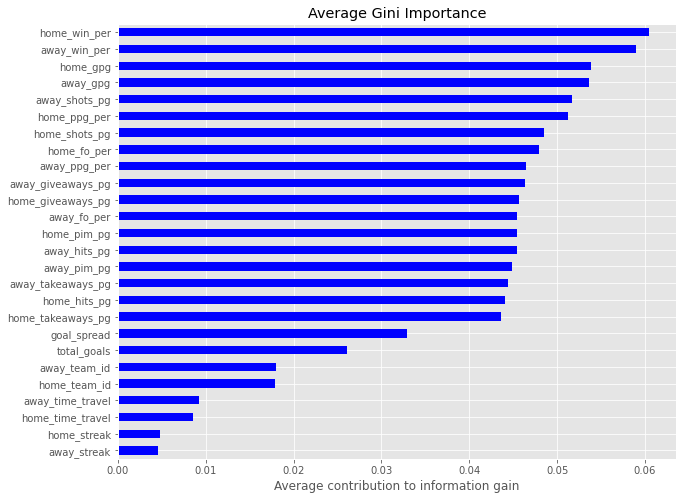

In [352]:
feat_scores = pd.Series(rf.feature_importances_,
                           index=X_train.columns)
feat_scores = feat_scores.sort_values()
ax = feat_scores.plot(kind='barh', 
                      figsize=(10,8),
                      color='b')
ax.set_title('Average Gini Importance')
ax.set_xlabel('Average contribution to information gain')

### **Gradient boost**

In [ ]:
gb = GradientBoostingClassifier(loss='deviance',
                                   learning_rate=0.005,
                                   n_estimators=500,
                                   min_samples_leaf=5)
gb.fit(X2_train, y2_train)
gb.score(X2_test, y2_test)

In [ ]:
gb3 = GradientBoostingClassifier(loss='deviance',
                                   learning_rate=0.005,
                                   n_estimators=500,
                                   min_samples_leaf=5)
gb3.fit(X3_train, y3_train)
gb3.score(X3_test, y3_test)

### **Breakdown by season**

The previous modeling included stats from all seasons put together.  Will breakdown cumulative stats by season to see if it improves accuracy.

In [287]:
season_df = game_df
season_team = team_game_df

In [288]:
season_team = pd.merge(season_team, season_df[['game_id', 'season']], on='game_id', how='left')

In [ ]:
'''
Below is cumulative stats broken down by seasons:
season_20112012
season_20122013
season_20132014
season_20142015
season_20152016
season_20162017
season_20172018
season_20182019
'''

##### **20112012**

In [289]:
# 2 dfs for 2011-2012 season
season_20112012 = season_df[season_df.season == 20112012]
filtered = season_team[season_team.season == 20112012]

In [290]:
# now calc cumulative stats
filtered['gpg'] = (filtered.groupby('team_id')['goals'].cumsum() - filtered['goals']) / filtered.groupby('team_id').cumcount()
filtered['win_per'] = (filtered.groupby('team_id')['won'].cumsum() - filtered['won']) / filtered.groupby('team_id').cumcount()
filtered['shots_pg'] = (filtered.groupby('team_id')['shots'].cumsum() - filtered['shots']) / filtered.groupby('team_id').cumcount()
filtered['hits_pg'] = (filtered.groupby('team_id')['hits'].cumsum() - filtered['hits']) / filtered.groupby('team_id').cumcount()
filtered['pim_pg'] = (filtered.groupby('team_id')['pim'].cumsum() - filtered['pim']) / filtered.groupby('team_id').cumcount()
filtered['hits_pg'] = (filtered.groupby('team_id')['hits'].cumsum() - filtered['hits']) / filtered.groupby('team_id').cumcount()
filtered['fo_per'] = (filtered.groupby('team_id')['faceOffWinPercentage'].cumsum() - filtered['faceOffWinPercentage']) / filtered.groupby('team_id').cumcount()
filtered['giveaways_pg'] = (filtered.groupby('team_id')['giveaways'].cumsum() - filtered['giveaways']) / filtered.groupby('team_id').cumcount()
filtered['takeaways_pg'] = (filtered.groupby('team_id')['takeaways'].cumsum() - filtered['takeaways']) / filtered.groupby('team_id').cumcount()
filtered['ppg_per'] = ((filtered.groupby('team_id')['powerPlayGoals'].cumsum() - filtered['powerPlayGoals'])) / ((filtered.groupby('team_id')['powerPlayOpportunities'].cumsum() - filtered['powerPlayOpportunities']))

<ipython-input-290-1286880b6bce>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['gpg'] = (filtered.groupby('team_id')['goals'].cumsum() - filtered['goals']) / filtered.groupby('team_id').cumcount()
<ipython-input-290-1286880b6bce>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['win_per'] = (filtered.groupby('team_id')['won'].cumsum() - filtered['won']) / filtered.groupby('team_id').cumcount()
<ipython-input-290-1286880b6bce>:4: SettingWithCopyWarning: 
A value is trying to be set on a 

In [291]:
# filter home team stats
filtered_h = filtered[filtered.HoA == 'home']
filtered_h = filtered_h.filter(items=['game_id', 'season', 'streak', 'time_travel', 'gpg', 'win_per', 'ppg_per', 'shots_pg', 'hits_pg', 'pim_pg', 'fo_per', 'giveaways_pg', 'takeaways_pg'])
filtered_h = filtered_h.rename(columns={'streak': 'home_streak', 'time_travel': 'home_time_travel', 'gpg': 'home_gpg', "win_per": "home_win_per", "ppg_per": "home_ppg_per", 'shots_pg': 'home_shots_pg', 'hits_pg': 'home_hits_pg', 'pim_pg': 'home_pim_pg', 'fo_per': 'home_fo_per', 'giveaways_pg': 'home_giveaways_pg',
       'takeaways_pg': 'home_takeaways_pg'})
# merge home team stats
season_20112012 = season_20112012.merge(filtered_h, on='game_id', how='left')

In [292]:
# merge home team stats
team_20112012 = filtered
season_20112012 = season_20112012.merge(filtered, on='game_id', how='left')

In [293]:
# filter away team stats
filtered_a = filtered[filtered.HoA == 'away']
filtered_a = filtered_a.filter(items=['game_id', 'season', 'streak', 'time_travel', 'gpg', 'win_per', 'ppg_per', 'shots_pg', 'hits_pg', 'pim_pg', 'fo_per', 'giveaways_pg', 'takeaways_pg'])
filtered_a = filtered_a.rename(columns={'streak': 'away_streak', 'time_travel': 'away_time_travel', 'gpg': 'away_gpg', "win_per": "away_win_per", "ppg_per": "away_ppg_per", 'shots_pg': 'away_shots_pg', 'hits_pg': 'away_hits_pg', 'pim_pg': 'away_pim_pg', 'fo_per': 'away_fo_per', 'giveaways_pg': 'away_giveaways_pg',
       'takeaways_pg': 'away_takeaways_pg'})

# merge away team stats
season_20112012 = season_20112012.merge(filtered_a, on='game_id', how='left')

In [294]:
season_20112012

,game_id,season_x,type,date_time,date_time_GMT,away_team_id,home_team_id,outcome,goal_spread,total_goals,...,away_streak,away_gpg,away_win_per,away_ppg_per,away_shots_pg,away_hits_pg,away_pim_pg,away_fo_per,away_giveaways_pg,away_takeaways_pg
0,2011030221,20112012,P,2012-04-29,2012-04-29T19:00:00Z,1,4,win,1,7,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011030221,20112012,P,2012-04-29,2012-04-29T19:00:00Z,1,4,win,1,7,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011030222,20112012,P,2012-05-01,2012-05-01T23:30:00Z,1,4,loss,3,5,...,False,3.000000,0.000000,0.333333,26.000000,31.000000,12.000000,44.900000,6.000000,7.000000
3,2011030222,20112012,P,2012-05-01,2012-05-01T23:30:00Z,1,4,loss,3,5,...,False,3.000000,0.000000,0.333333,26.000000,31.000000,12.000000,44.900000,6.000000,7.000000
4,2011030223,20112012,P,2012-05-03,2012-05-03T23:30:00Z,4,1,win,1,7,...,False,2.500000,0.500000,0.090909,28.000000,25.500000,19.000000,52.100000,11.000000,5.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2627,2011020713,20112012,R,2012-01-22,2012-01-22T20:00:00Z,6,4,loss,1,11,...,True,3.068182,0.579545,0.164179,32.545455,23.068182,12.704545,54.155682,6.556818,5.522727
2628,2011021219,20112012,R,2012-04-07,2012-04-07T20:00:00Z,4,5,win,2,6,...,False,3.250000,0.565217,0.215633,31.728261,25.891304,16.380435,48.679348,7.847826,5.728261
2629,2011021219,20112012,R,2012-04-07,2012-04-07T20:00:00Z,4,5,win,2,6,...,False,3.250000,0.565217,0.215633,31.728261,25.891304,16.380435,48.679348,7.847826,5.728261
2630,2011021085,20112012,R,2012-03-19,2012-03-19T23:30:00Z,15,17,loss,2,8,...,False,2.547368,0.505263,0.160714,28.000000,25.315789,9.294737,50.088421,9.315789,7.389474


In [295]:
season_20112012 = season_20112012.drop(columns=['season_x', 'season_y', 'game_id', 'type', 'date_time', 'date_time_GMT'])


In [296]:
season_20112012 = season_20112012.replace({'home_streak': False}, 0)
season_20112012 = season_20112012.replace({'home_streak': True}, 1)
season_20112012 = season_20112012.replace({'away_streak': False}, 0)
season_20112012 = season_20112012.replace({'away_streak': True}, 1)
season_20112012 = season_20112012.replace({'outcome': 'loss'}, 0)
season_20112012 = season_20112012.replace({'outcome': 'win'}, 1)

In [297]:
season_20112012 = season_20112012.fillna(0)

In [298]:
season_20112012 = season_20112012.drop(labels=['team_id', 'HoA', 'won', 'settled_in', 'head_coach', 'goals', 'shots', 'hits', 'pim', 'powerPlayOpportunities', 'powerPlayGoals',
       'faceOffWinPercentage', 'giveaways', 'takeaways', 'streak', 'gpg',
       'win_per', 'shots_pg', 'hits_pg', 'pim_pg', 'fo_per', 'giveaways_pg',
       'takeaways_pg', 'ppg_per'], axis=1)

##### **2012-2013**

In [299]:
season_20122013 = season_df[season_df.season == 20122013]
filtered = season_team[season_team.season == 20122013]

# now calc cumulative stats
filtered['gpg'] = (filtered.groupby('team_id')['goals'].cumsum() - filtered['goals']) / filtered.groupby('team_id').cumcount()
filtered['win_per'] = (filtered.groupby('team_id')['won'].cumsum() - filtered['won']) / filtered.groupby('team_id').cumcount()
filtered['shots_pg'] = (filtered.groupby('team_id')['shots'].cumsum() - filtered['shots']) / filtered.groupby('team_id').cumcount()
filtered['hits_pg'] = (filtered.groupby('team_id')['hits'].cumsum() - filtered['hits']) / filtered.groupby('team_id').cumcount()
filtered['pim_pg'] = (filtered.groupby('team_id')['pim'].cumsum() - filtered['pim']) / filtered.groupby('team_id').cumcount()
filtered['hits_pg'] = (filtered.groupby('team_id')['hits'].cumsum() - filtered['hits']) / filtered.groupby('team_id').cumcount()
filtered['fo_per'] = (filtered.groupby('team_id')['faceOffWinPercentage'].cumsum() - filtered['faceOffWinPercentage']) / filtered.groupby('team_id').cumcount()
filtered['giveaways_pg'] = (filtered.groupby('team_id')['giveaways'].cumsum() - filtered['giveaways']) / filtered.groupby('team_id').cumcount()
filtered['takeaways_pg'] = (filtered.groupby('team_id')['takeaways'].cumsum() - filtered['takeaways']) / filtered.groupby('team_id').cumcount()
filtered['ppg_per'] = ((filtered.groupby('team_id')['powerPlayGoals'].cumsum() - filtered['powerPlayGoals'])) / ((filtered.groupby('team_id')['powerPlayOpportunities'].cumsum() - filtered['powerPlayOpportunities']))

# filter home team stats
filtered_h = filtered[filtered.HoA == 'home']
filtered_h = filtered_h.filter(items=['game_id', 'season', 'streak', 'time_travel', 'gpg', 'win_per', 'ppg_per', 'shots_pg', 'hits_pg', 'pim_pg', 'fo_per', 'giveaways_pg', 'takeaways_pg'])
filtered_h = filtered_h.rename(columns={'streak': 'home_streak', 'time_travel': 'home_time_travel', 'gpg': 'home_gpg', "win_per": "home_win_per", "ppg_per": "home_ppg_per", 'shots_pg': 'home_shots_pg', 'hits_pg': 'home_hits_pg', 'pim_pg': 'home_pim_pg', 'fo_per': 'home_fo_per', 'giveaways_pg': 'home_giveaways_pg',
       'takeaways_pg': 'home_takeaways_pg'})
# merge home team stats
season_20122013 = season_20122013.merge(filtered_h, on='game_id', how='left')

# filter away team stats
filtered_a = filtered[filtered.HoA == 'away']
filtered_a = filtered_a.filter(items=['game_id', 'season', 'streak', 'time_travel', 'gpg', 'win_per', 'ppg_per', 'shots_pg', 'hits_pg', 'pim_pg', 'fo_per', 'giveaways_pg', 'takeaways_pg'])
filtered_a = filtered_a.rename(columns={'streak': 'away_streak', 'time_travel': 'away_time_travel', 'gpg': 'away_gpg', "win_per": "away_win_per", "ppg_per": "away_ppg_per", 'shots_pg': 'away_shots_pg', 'hits_pg': 'away_hits_pg', 'pim_pg': 'away_pim_pg', 'fo_per': 'away_fo_per', 'giveaways_pg': 'away_giveaways_pg',
       'takeaways_pg': 'away_takeaways_pg'})

# merge away team stats
season_20122013 = season_20122013.merge(filtered_a, on='game_id', how='left')

<ipython-input-299-1822620414ea>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['gpg'] = (filtered.groupby('team_id')['goals'].cumsum() - filtered['goals']) / filtered.groupby('team_id').cumcount()
<ipython-input-299-1822620414ea>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['win_per'] = (filtered.groupby('team_id')['won'].cumsum() - filtered['won']) / filtered.groupby('team_id').cumcount()
<ipython-input-299-1822620414ea>:7: SettingWithCopyWarning: 
A value is trying to be set on a 

In [300]:
season_20122013 = season_20122013.drop(columns=['season_x', 'season_y', 'game_id', 'type', 'date_time', 'date_time_GMT'])
season_20122013 = season_20122013.replace({'home_streak': False}, 0)
season_20122013 = season_20122013.replace({'home_streak': True}, 1)
season_20122013 = season_20122013.replace({'away_streak': False}, 0)
season_20122013 = season_20122013.replace({'away_streak': True}, 1)
season_20122013 = season_20122013.replace({'outcome': 'loss'}, 0)
season_20122013 = season_20122013.replace({'outcome': 'win'}, 1)
season_20122013.fillna(0)

,away_team_id,home_team_id,outcome,goal_spread,total_goals,home_streak,home_gpg,home_win_per,home_ppg_per,home_shots_pg,...,away_streak,away_gpg,away_win_per,away_ppg_per,away_shots_pg,away_hits_pg,away_pim_pg,away_fo_per,away_giveaways_pg,away_takeaways_pg
0,3,6,1,1,5,1.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,3,6,1,3,7,1.0,3.000000,1.000000,0.250000,48.000000,...,0.0,2.000000,0.000000,0.000000,35.000000,44.000000,8.000000,44.800000,17.000000,7.000000
2,6,3,0,1,3,0.0,2.000000,0.000000,0.000000,36.000000,...,1.0,4.000000,1.000000,0.200000,40.000000,43.500000,12.500000,51.750000,10.000000,5.500000
3,6,3,1,1,7,0.0,1.666667,0.000000,0.000000,32.000000,...,1.0,3.333333,1.000000,0.200000,38.000000,38.333333,10.333333,55.100000,10.000000,6.000000
4,3,6,1,2,4,0.0,3.250000,0.750000,0.333333,38.500000,...,1.0,2.250000,0.250000,0.071429,32.000000,38.500000,7.250000,45.250000,8.500000,6.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
801,23,19,1,1,3,1.0,2.557692,0.576923,0.193750,27.769231,...,0.0,2.529412,0.509804,0.156977,28.549020,22.450980,12.921569,47.427451,7.470588,6.862745
802,19,21,1,1,1,1.0,2.404255,0.319149,0.151079,29.680851,...,1.0,2.528302,0.584906,0.189024,27.924528,25.301887,10.735849,50.745283,5.018868,5.886792
803,20,27,1,4,4,0.0,2.489362,0.425532,0.148810,30.765957,...,1.0,2.723404,0.404255,0.201299,26.872340,19.021277,10.872340,46.951064,8.829787,7.191489
804,26,16,1,1,5,1.0,3.000000,0.728571,0.148837,32.057143,...,0.0,2.553846,0.553846,0.186916,28.676923,33.353846,9.400000,51.089231,8.876923,4.815385


In [301]:
season_20122013 = season_20122013.fillna(0)

In [302]:
season_20122013.columns

Index(['away_team_id', 'home_team_id', 'outcome', 'goal_spread', 'total_goals',
       'home_streak', 'home_gpg', 'home_win_per', 'home_ppg_per',
       'home_shots_pg', 'home_hits_pg', 'home_pim_pg', 'home_fo_per',
       'home_giveaways_pg', 'home_takeaways_pg', 'season', 'away_streak',
       'away_gpg', 'away_win_per', 'away_ppg_per', 'away_shots_pg',
       'away_hits_pg', 'away_pim_pg', 'away_fo_per', 'away_giveaways_pg',
       'away_takeaways_pg'],
      dtype='object')

In [303]:
season_20122013 = season_20122013.drop(labels=['season'], axis=1)

##### **2013-2014**

In [304]:
season_20132014 = season_df[season_df.season == 20132014]
filtered = season_team[season_team.season == 20132014]

# now calc cumulative stats
filtered['gpg'] = (filtered.groupby('team_id')['goals'].cumsum() - filtered['goals']) / filtered.groupby('team_id').cumcount()
filtered['win_per'] = (filtered.groupby('team_id')['won'].cumsum() - filtered['won']) / filtered.groupby('team_id').cumcount()
filtered['shots_pg'] = (filtered.groupby('team_id')['shots'].cumsum() - filtered['shots']) / filtered.groupby('team_id').cumcount()
filtered['hits_pg'] = (filtered.groupby('team_id')['hits'].cumsum() - filtered['hits']) / filtered.groupby('team_id').cumcount()
filtered['pim_pg'] = (filtered.groupby('team_id')['pim'].cumsum() - filtered['pim']) / filtered.groupby('team_id').cumcount()
filtered['hits_pg'] = (filtered.groupby('team_id')['hits'].cumsum() - filtered['hits']) / filtered.groupby('team_id').cumcount()
filtered['fo_per'] = (filtered.groupby('team_id')['faceOffWinPercentage'].cumsum() - filtered['faceOffWinPercentage']) / filtered.groupby('team_id').cumcount()
filtered['giveaways_pg'] = (filtered.groupby('team_id')['giveaways'].cumsum() - filtered['giveaways']) / filtered.groupby('team_id').cumcount()
filtered['takeaways_pg'] = (filtered.groupby('team_id')['takeaways'].cumsum() - filtered['takeaways']) / filtered.groupby('team_id').cumcount()
filtered['ppg_per'] = ((filtered.groupby('team_id')['powerPlayGoals'].cumsum() - filtered['powerPlayGoals'])) / ((filtered.groupby('team_id')['powerPlayOpportunities'].cumsum() - filtered['powerPlayOpportunities']))

# filter home team stats
filtered_h = filtered[filtered.HoA == 'home']
filtered_h = filtered_h.filter(items=['game_id', 'season', 'streak', 'time_travel', 'gpg', 'win_per', 'ppg_per', 'shots_pg', 'hits_pg', 'pim_pg', 'fo_per', 'giveaways_pg', 'takeaways_pg'])
filtered_h = filtered_h.rename(columns={'streak': 'home_streak', 'time_travel': 'home_time_travel', 'gpg': 'home_gpg', "win_per": "home_win_per", "ppg_per": "home_ppg_per", 'shots_pg': 'home_shots_pg', 'hits_pg': 'home_hits_pg', 'pim_pg': 'home_pim_pg', 'fo_per': 'home_fo_per', 'giveaways_pg': 'home_giveaways_pg',
       'takeaways_pg': 'home_takeaways_pg'})
# merge home team stats
season_20132014 = season_20132014.merge(filtered_h, on='game_id', how='left')

# filter away team stats
filtered_a = filtered[filtered.HoA == 'away']
filtered_a = filtered_a.filter(items=['game_id', 'season', 'streak', 'time_travel', 'gpg', 'win_per', 'ppg_per', 'shots_pg', 'hits_pg', 'pim_pg', 'fo_per', 'giveaways_pg', 'takeaways_pg'])
filtered_a = filtered_a.rename(columns={'streak': 'away_streak', 'time_travel': 'away_time_travel', 'gpg': 'away_gpg', "win_per": "away_win_per", "ppg_per": "away_ppg_per", 'shots_pg': 'away_shots_pg', 'hits_pg': 'away_hits_pg', 'pim_pg': 'away_pim_pg', 'fo_per': 'away_fo_per', 'giveaways_pg': 'away_giveaways_pg',
       'takeaways_pg': 'away_takeaways_pg'})

# merge away team stats
season_20132014 = season_20132014.merge(filtered_a, on='game_id', how='left')

<ipython-input-304-9a8232818a2d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['gpg'] = (filtered.groupby('team_id')['goals'].cumsum() - filtered['goals']) / filtered.groupby('team_id').cumcount()
<ipython-input-304-9a8232818a2d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['win_per'] = (filtered.groupby('team_id')['won'].cumsum() - filtered['won']) / filtered.groupby('team_id').cumcount()
<ipython-input-304-9a8232818a2d>:7: SettingWithCopyWarning: 
A value is trying to be set on a 

In [305]:
season_20132014 = season_20132014.drop(columns=['season_x', 'season_y', 'game_id', 'type', 'date_time', 'date_time_GMT'])
season_20132014 = season_20132014.replace({'home_streak': False}, 0)
season_20132014 = season_20132014.replace({'home_streak': True}, 1)
season_20132014 = season_20132014.replace({'away_streak': False}, 0)
season_20132014 = season_20132014.replace({'away_streak': True}, 1)
season_20132014 = season_20132014.replace({'outcome': 'loss'}, 0)
season_20132014 = season_20132014.replace({'outcome': 'win'}, 1)
season_20132014.fillna(0)

,away_team_id,home_team_id,outcome,goal_spread,total_goals,home_streak,home_gpg,home_win_per,home_ppg_per,home_shots_pg,...,away_streak,away_gpg,away_win_per,away_ppg_per,away_shots_pg,away_hits_pg,away_pim_pg,away_fo_per,away_giveaways_pg,away_takeaways_pg
0,16,19,1,1,7,0.0,0.000000,0.000000,0.000000,0.000000,...,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,16,19,1,1,7,1.0,4.000000,1.000000,0.000000,52.000000,...,0.0,3.000000,0.000000,0.166667,42.000000,27.000000,8.000000,56.900000,12.000000,6.000000
2,19,16,1,2,2,0.0,3.000000,0.000000,0.100000,35.000000,...,1.0,4.000000,1.000000,0.076923,41.500000,34.000000,16.000000,45.850000,4.500000,12.000000
3,19,16,1,1,7,1.0,2.666667,0.333333,0.071429,31.666667,...,0.0,2.666667,0.666667,0.062500,39.000000,36.333333,13.333333,44.200000,4.000000,11.000000
4,16,19,0,1,5,0.0,2.750000,0.500000,0.095238,37.500000,...,1.0,3.000000,0.500000,0.125000,32.250000,26.000000,16.750000,54.950000,9.750000,5.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1318,2,1,0,1,5,1.0,2.407407,0.432099,0.195833,26.827160,...,1.0,2.641975,0.407407,0.175824,30.950617,25.469136,12.382716,46.979012,9.086420,8.074074
1319,22,4,1,2,6,1.0,2.784091,0.500000,0.205788,29.943182,...,1.0,2.432099,0.358025,0.168539,26.950617,21.296296,11.666667,49.060494,11.827160,7.111111
1320,27,3,1,1,7,0.0,2.584906,0.537736,0.167123,32.226415,...,1.0,2.555556,0.456790,0.197842,30.592593,26.641975,9.925926,51.908642,5.654321,6.259259
1321,19,18,0,3,5,1.0,2.629630,0.469136,0.194915,29.024691,...,0.0,2.862069,0.609195,0.186495,29.793103,23.758621,13.850575,51.502299,4.206897,6.793103


In [306]:
season_20132014 = season_20132014.fillna(0)

In [307]:
season_20132014 = season_20132014.drop(labels=['season'], axis=1)

##### **2014-2015**

In [308]:
season_20142015 = season_df[season_df.season == 20142015]
filtered = season_team[season_team.season == 20142015]

# now calc cumulative stats
filtered['gpg'] = (filtered.groupby('team_id')['goals'].cumsum() - filtered['goals']) / filtered.groupby('team_id').cumcount()
filtered['win_per'] = (filtered.groupby('team_id')['won'].cumsum() - filtered['won']) / filtered.groupby('team_id').cumcount()
filtered['shots_pg'] = (filtered.groupby('team_id')['shots'].cumsum() - filtered['shots']) / filtered.groupby('team_id').cumcount()
filtered['hits_pg'] = (filtered.groupby('team_id')['hits'].cumsum() - filtered['hits']) / filtered.groupby('team_id').cumcount()
filtered['pim_pg'] = (filtered.groupby('team_id')['pim'].cumsum() - filtered['pim']) / filtered.groupby('team_id').cumcount()
filtered['hits_pg'] = (filtered.groupby('team_id')['hits'].cumsum() - filtered['hits']) / filtered.groupby('team_id').cumcount()
filtered['fo_per'] = (filtered.groupby('team_id')['faceOffWinPercentage'].cumsum() - filtered['faceOffWinPercentage']) / filtered.groupby('team_id').cumcount()
filtered['giveaways_pg'] = (filtered.groupby('team_id')['giveaways'].cumsum() - filtered['giveaways']) / filtered.groupby('team_id').cumcount()
filtered['takeaways_pg'] = (filtered.groupby('team_id')['takeaways'].cumsum() - filtered['takeaways']) / filtered.groupby('team_id').cumcount()
filtered['ppg_per'] = ((filtered.groupby('team_id')['powerPlayGoals'].cumsum() - filtered['powerPlayGoals'])) / ((filtered.groupby('team_id')['powerPlayOpportunities'].cumsum() - filtered['powerPlayOpportunities']))

# filter home team stats
filtered_h = filtered[filtered.HoA == 'home']
filtered_h = filtered_h.filter(items=['game_id', 'season', 'streak', 'time_travel', 'gpg', 'win_per', 'ppg_per', 'shots_pg', 'hits_pg', 'pim_pg', 'fo_per', 'giveaways_pg', 'takeaways_pg'])
filtered_h = filtered_h.rename(columns={'streak': 'home_streak', 'time_travel': 'home_time_travel', 'gpg': 'home_gpg', "win_per": "home_win_per", "ppg_per": "home_ppg_per", 'shots_pg': 'home_shots_pg', 'hits_pg': 'home_hits_pg', 'pim_pg': 'home_pim_pg', 'fo_per': 'home_fo_per', 'giveaways_pg': 'home_giveaways_pg',
       'takeaways_pg': 'home_takeaways_pg'})
# merge home team stats
season_20142015 = season_20142015.merge(filtered_h, on='game_id', how='left')

# filter away team stats
filtered_a = filtered[filtered.HoA == 'away']
filtered_a = filtered_a.filter(items=['game_id', 'season', 'streak', 'time_travel', 'gpg', 'win_per', 'ppg_per', 'shots_pg', 'hits_pg', 'pim_pg', 'fo_per', 'giveaways_pg', 'takeaways_pg'])
filtered_a = filtered_a.rename(columns={'streak': 'away_streak', 'time_travel': 'away_time_travel', 'gpg': 'away_gpg', "win_per": "away_win_per", "ppg_per": "away_ppg_per", 'shots_pg': 'away_shots_pg', 'hits_pg': 'away_hits_pg', 'pim_pg': 'away_pim_pg', 'fo_per': 'away_fo_per', 'giveaways_pg': 'away_giveaways_pg',
       'takeaways_pg': 'away_takeaways_pg'})

# merge away team stats
season_20142015 = season_20142015.merge(filtered_a, on='game_id', how='left')

<ipython-input-308-a0d0b1820bbd>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['gpg'] = (filtered.groupby('team_id')['goals'].cumsum() - filtered['goals']) / filtered.groupby('team_id').cumcount()
<ipython-input-308-a0d0b1820bbd>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['win_per'] = (filtered.groupby('team_id')['won'].cumsum() - filtered['won']) / filtered.groupby('team_id').cumcount()
<ipython-input-308-a0d0b1820bbd>:7: SettingWithCopyWarning: 
A value is trying to be set on a 

In [309]:
season_20142015 = season_20142015.drop(columns=['season_x', 'season_y', 'game_id', 'type', 'date_time', 'date_time_GMT'])
season_20142015 = season_20142015.replace({'home_streak': False}, 0)
season_20142015 = season_20142015.replace({'home_streak': True}, 1)
season_20142015 = season_20142015.replace({'away_streak': False}, 0)
season_20142015 = season_20142015.replace({'away_streak': True}, 1)
season_20142015 = season_20142015.replace({'outcome': 'loss'}, 0)
season_20142015 = season_20142015.replace({'outcome': 'win'}, 1)
season_20142015.fillna(0)

,away_team_id,home_team_id,outcome,goal_spread,total_goals,home_streak,home_gpg,home_win_per,home_ppg_per,home_shots_pg,...,away_streak,away_gpg,away_win_per,away_ppg_per,away_shots_pg,away_hits_pg,away_pim_pg,away_fo_per,away_giveaways_pg,away_takeaways_pg
0,16,14,0,1,3,1.0,0.000000,0.000000,0.000000,0.000000,...,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,16,14,1,1,7,0.0,1.000000,0.000000,0.000000,23.000000,...,1.0,2.000000,1.000000,0.000000,21.000000,21.000000,4.000000,47.400000,11.000000,5.000000
2,14,16,0,1,5,0.0,2.500000,0.500000,0.166667,25.000000,...,1.0,2.500000,0.500000,0.200000,23.500000,31.000000,6.000000,43.900000,11.500000,5.500000
3,14,16,1,1,3,0.0,2.333333,0.333333,0.250000,29.333333,...,1.0,2.666667,0.666667,0.142857,26.333333,36.000000,6.000000,43.200000,11.000000,6.000000
4,16,14,0,1,3,0.0,2.250000,0.500000,0.090909,26.000000,...,1.0,2.250000,0.500000,0.181818,26.750000,27.500000,6.000000,58.975000,12.250000,6.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1314,2,24,0,1,5,1.0,2.917526,0.639175,0.172662,30.855670,...,0.0,2.931034,0.563218,0.170909,33.333333,33.724138,8.908046,48.816092,11.264368,9.459770
1315,3,4,0,3,3,1.0,2.617284,0.407407,0.240000,29.469136,...,1.0,2.900000,0.630000,0.177083,31.450000,24.940000,8.510000,46.712000,9.880000,8.030000
1316,7,22,1,1,5,0.0,2.345679,0.283951,0.179039,28.358025,...,0.0,1.864198,0.283951,0.134529,24.246914,26.802469,10.395062,44.950617,6.172840,4.617284
1317,13,2,0,2,6,1.0,2.931818,0.568182,0.176259,33.363636,...,1.0,2.395062,0.456790,0.159836,30.703704,27.716049,8.975309,48.625926,5.679012,5.839506


In [310]:
season_20142015 = season_20142015.fillna(0)

In [311]:
season_20142015 = season_20142015.drop(labels=['season'], axis=1)

##### **2015-2016**

In [312]:
season_20152016 = season_df[season_df.season == 20152016]
filtered = season_team[season_team.season == 20152016]

# now calc cumulative stats
filtered['gpg'] = (filtered.groupby('team_id')['goals'].cumsum() - filtered['goals']) / filtered.groupby('team_id').cumcount()
filtered['win_per'] = (filtered.groupby('team_id')['won'].cumsum() - filtered['won']) / filtered.groupby('team_id').cumcount()
filtered['shots_pg'] = (filtered.groupby('team_id')['shots'].cumsum() - filtered['shots']) / filtered.groupby('team_id').cumcount()
filtered['hits_pg'] = (filtered.groupby('team_id')['hits'].cumsum() - filtered['hits']) / filtered.groupby('team_id').cumcount()
filtered['pim_pg'] = (filtered.groupby('team_id')['pim'].cumsum() - filtered['pim']) / filtered.groupby('team_id').cumcount()
filtered['hits_pg'] = (filtered.groupby('team_id')['hits'].cumsum() - filtered['hits']) / filtered.groupby('team_id').cumcount()
filtered['fo_per'] = (filtered.groupby('team_id')['faceOffWinPercentage'].cumsum() - filtered['faceOffWinPercentage']) / filtered.groupby('team_id').cumcount()
filtered['giveaways_pg'] = (filtered.groupby('team_id')['giveaways'].cumsum() - filtered['giveaways']) / filtered.groupby('team_id').cumcount()
filtered['takeaways_pg'] = (filtered.groupby('team_id')['takeaways'].cumsum() - filtered['takeaways']) / filtered.groupby('team_id').cumcount()
filtered['ppg_per'] = ((filtered.groupby('team_id')['powerPlayGoals'].cumsum() - filtered['powerPlayGoals'])) / ((filtered.groupby('team_id')['powerPlayOpportunities'].cumsum() - filtered['powerPlayOpportunities']))

# filter home team stats
filtered_h = filtered[filtered.HoA == 'home']
filtered_h = filtered_h.filter(items=['game_id', 'season', 'streak', 'time_travel', 'gpg', 'win_per', 'ppg_per', 'shots_pg', 'hits_pg', 'pim_pg', 'fo_per', 'giveaways_pg', 'takeaways_pg'])
filtered_h = filtered_h.rename(columns={'streak': 'home_streak', 'time_travel': 'home_time_travel', 'gpg': 'home_gpg', "win_per": "home_win_per", "ppg_per": "home_ppg_per", 'shots_pg': 'home_shots_pg', 'hits_pg': 'home_hits_pg', 'pim_pg': 'home_pim_pg', 'fo_per': 'home_fo_per', 'giveaways_pg': 'home_giveaways_pg',
       'takeaways_pg': 'home_takeaways_pg'})
# merge home team stats
season_20152016 = season_20152016.merge(filtered_h, on='game_id', how='left')

# filter away team stats
filtered_a = filtered[filtered.HoA == 'away']
filtered_a = filtered_a.filter(items=['game_id', 'season', 'streak', 'time_travel', 'gpg', 'win_per', 'ppg_per', 'shots_pg', 'hits_pg', 'pim_pg', 'fo_per', 'giveaways_pg', 'takeaways_pg'])
filtered_a = filtered_a.rename(columns={'streak': 'away_streak', 'time_travel': 'away_time_travel', 'gpg': 'away_gpg', "win_per": "away_win_per", "ppg_per": "away_ppg_per", 'shots_pg': 'away_shots_pg', 'hits_pg': 'away_hits_pg', 'pim_pg': 'away_pim_pg', 'fo_per': 'away_fo_per', 'giveaways_pg': 'away_giveaways_pg',
       'takeaways_pg': 'away_takeaways_pg'})

# merge away team stats
season_20152016 = season_20152016.merge(filtered_a, on='game_id', how='left')

<ipython-input-312-b97e7999fd3e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['gpg'] = (filtered.groupby('team_id')['goals'].cumsum() - filtered['goals']) / filtered.groupby('team_id').cumcount()
<ipython-input-312-b97e7999fd3e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['win_per'] = (filtered.groupby('team_id')['won'].cumsum() - filtered['won']) / filtered.groupby('team_id').cumcount()
<ipython-input-312-b97e7999fd3e>:7: SettingWithCopyWarning: 
A value is trying to be set on a 

In [313]:
season_20152016 = season_20152016.drop(columns=['season_x', 'season_y', 'game_id', 'type', 'date_time', 'date_time_GMT'])
season_20152016 = season_20152016.replace({'home_streak': False}, 0)
season_20152016 = season_20152016.replace({'home_streak': True}, 1)
season_20152016 = season_20152016.replace({'away_streak': False}, 0)
season_20152016 = season_20152016.replace({'away_streak': True}, 1)
season_20152016 = season_20152016.replace({'outcome': 'loss'}, 0)
season_20152016 = season_20152016.replace({'outcome': 'win'}, 1)
season_20152016.fillna(0)

,away_team_id,home_team_id,outcome,goal_spread,total_goals,home_streak,home_gpg,home_win_per,home_ppg_per,home_shots_pg,...,away_streak,away_gpg,away_win_per,away_ppg_per,away_shots_pg,away_hits_pg,away_pim_pg,away_fo_per,away_giveaways_pg,away_takeaways_pg
0,3,5,1,3,7,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,3,5,0,2,6,1.0,5.000000,1.000000,0.200000,31.000000,...,0.0,2.000000,0.000000,0.200000,37.000000,50.000000,10.000000,48.500000,2.000000,3.000000
2,5,3,0,2,4,1.0,3.000000,0.500000,0.125000,32.500000,...,0.0,3.500000,0.500000,0.300000,31.000000,30.000000,12.500000,53.600000,10.000000,3.000000
3,5,3,0,5,5,0.0,2.333333,0.333333,0.083333,27.333333,...,1.0,3.333333,0.666667,0.307692,31.000000,30.000000,12.333333,53.466667,8.333333,4.000000
4,3,5,1,3,9,1.0,3.750000,0.750000,0.368421,31.250000,...,0.0,1.750000,0.250000,0.062500,28.250000,44.250000,13.250000,49.325000,8.250000,6.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1316,1,12,0,4,6,0.0,2.407407,0.432099,0.169492,29.876543,...,1.0,2.185185,0.456790,0.198413,24.407407,22.382716,9.827160,46.814815,6.246914,5.592593
1317,21,2,1,2,8,1.0,2.695652,0.532609,0.188679,29.869565,...,0.0,2.580247,0.481481,0.182510,28.654321,22.185185,9.481481,49.971605,6.209877,5.555556
1318,30,53,0,1,7,0.0,2.530864,0.432099,0.180887,27.604938,...,0.0,2.597701,0.448276,0.188889,28.816092,17.689655,6.678161,52.413793,6.689655,6.172414
1319,26,17,1,1,5,0.0,2.488372,0.476744,0.174825,29.813953,...,1.0,2.697674,0.569767,0.204082,31.546512,31.360465,10.465116,50.708140,9.244186,4.209302


In [314]:
season_20152016 = season_20152016.fillna(0)

In [315]:
season_20152016 = season_20152016.drop(labels=['season'], axis=1)

##### **2016-2017**

In [316]:
season_20162017 = season_df[season_df.season == 20162017]
filtered = season_team[season_team.season == 20162017]

# now calc cumulative stats
filtered['gpg'] = (filtered.groupby('team_id')['goals'].cumsum() - filtered['goals']) / filtered.groupby('team_id').cumcount()
filtered['win_per'] = (filtered.groupby('team_id')['won'].cumsum() - filtered['won']) / filtered.groupby('team_id').cumcount()
filtered['shots_pg'] = (filtered.groupby('team_id')['shots'].cumsum() - filtered['shots']) / filtered.groupby('team_id').cumcount()
filtered['hits_pg'] = (filtered.groupby('team_id')['hits'].cumsum() - filtered['hits']) / filtered.groupby('team_id').cumcount()
filtered['pim_pg'] = (filtered.groupby('team_id')['pim'].cumsum() - filtered['pim']) / filtered.groupby('team_id').cumcount()
filtered['hits_pg'] = (filtered.groupby('team_id')['hits'].cumsum() - filtered['hits']) / filtered.groupby('team_id').cumcount()
filtered['fo_per'] = (filtered.groupby('team_id')['faceOffWinPercentage'].cumsum() - filtered['faceOffWinPercentage']) / filtered.groupby('team_id').cumcount()
filtered['giveaways_pg'] = (filtered.groupby('team_id')['giveaways'].cumsum() - filtered['giveaways']) / filtered.groupby('team_id').cumcount()
filtered['takeaways_pg'] = (filtered.groupby('team_id')['takeaways'].cumsum() - filtered['takeaways']) / filtered.groupby('team_id').cumcount()
filtered['ppg_per'] = ((filtered.groupby('team_id')['powerPlayGoals'].cumsum() - filtered['powerPlayGoals'])) / ((filtered.groupby('team_id')['powerPlayOpportunities'].cumsum() - filtered['powerPlayOpportunities']))

# filter home team stats
filtered_h = filtered[filtered.HoA == 'home']
filtered_h = filtered_h.filter(items=['game_id', 'season', 'streak', 'time_travel', 'gpg', 'win_per', 'ppg_per', 'shots_pg', 'hits_pg', 'pim_pg', 'fo_per', 'giveaways_pg', 'takeaways_pg'])
filtered_h = filtered_h.rename(columns={'streak': 'home_streak', 'time_travel': 'home_time_travel', 'gpg': 'home_gpg', "win_per": "home_win_per", "ppg_per": "home_ppg_per", 'shots_pg': 'home_shots_pg', 'hits_pg': 'home_hits_pg', 'pim_pg': 'home_pim_pg', 'fo_per': 'home_fo_per', 'giveaways_pg': 'home_giveaways_pg',
       'takeaways_pg': 'home_takeaways_pg'})
# merge home team stats
season_20162017 = season_20162017.merge(filtered_h, on='game_id', how='left')

# filter away team stats
filtered_a = filtered[filtered.HoA == 'away']
filtered_a = filtered_a.filter(items=['game_id', 'season', 'streak', 'time_travel', 'gpg', 'win_per', 'ppg_per', 'shots_pg', 'hits_pg', 'pim_pg', 'fo_per', 'giveaways_pg', 'takeaways_pg'])
filtered_a = filtered_a.rename(columns={'streak': 'away_streak', 'time_travel': 'away_time_travel', 'gpg': 'away_gpg', "win_per": "away_win_per", "ppg_per": "away_ppg_per", 'shots_pg': 'away_shots_pg', 'hits_pg': 'away_hits_pg', 'pim_pg': 'away_pim_pg', 'fo_per': 'away_fo_per', 'giveaways_pg': 'away_giveaways_pg',
       'takeaways_pg': 'away_takeaways_pg'})

# merge away team stats
season_20162017 = season_20162017.merge(filtered_a, on='game_id', how='left')

<ipython-input-316-8eab57dc2d27>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['gpg'] = (filtered.groupby('team_id')['goals'].cumsum() - filtered['goals']) / filtered.groupby('team_id').cumcount()
<ipython-input-316-8eab57dc2d27>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['win_per'] = (filtered.groupby('team_id')['won'].cumsum() - filtered['won']) / filtered.groupby('team_id').cumcount()
<ipython-input-316-8eab57dc2d27>:7: SettingWithCopyWarning: 
A value is trying to be set on a 

In [317]:
season_20162017 = season_20162017.drop(columns=['season_x', 'season_y', 'game_id', 'type', 'date_time', 'date_time_GMT'])
season_20162017 = season_20162017.replace({'home_streak': False}, 0)
season_20162017 = season_20162017.replace({'home_streak': True}, 1)
season_20162017 = season_20162017.replace({'away_streak': False}, 0)
season_20162017 = season_20162017.replace({'away_streak': True}, 1)
season_20162017 = season_20162017.replace({'outcome': 'loss'}, 0)
season_20162017 = season_20162017.replace({'outcome': 'win'}, 1)
season_20162017.fillna(0)

,away_team_id,home_team_id,outcome,goal_spread,total_goals,home_streak,home_gpg,home_win_per,home_ppg_per,home_shots_pg,...,away_streak,away_gpg,away_win_per,away_ppg_per,away_shots_pg,away_hits_pg,away_pim_pg,away_fo_per,away_giveaways_pg,away_takeaways_pg
0,20,24,1,1,5,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,20,24,1,1,5,1.0,3.000000,1.000000,0.285714,41.000000,...,0.0,2.000000,0.000000,0.200000,32.000000,33.000000,14.000000,37.200000,11.000000,8.000000
2,24,20,0,1,9,0.0,2.000000,0.000000,0.250000,34.500000,...,1.0,3.000000,1.000000,0.272727,35.000000,34.000000,12.500000,60.800000,16.500000,4.500000
3,24,20,0,2,4,0.0,2.666667,0.000000,0.384615,33.666667,...,1.0,3.666667,1.000000,0.272727,32.333333,30.333333,12.333333,56.300000,12.666667,4.333333
4,18,19,0,1,7,0.0,0.000000,0.000000,0.000000,0.000000,...,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1312,6,52,0,3,5,1.0,3.000000,0.487500,0.183594,29.737500,...,0.0,2.770115,0.517241,0.218750,32.885057,23.218391,10.080460,52.890805,8.701149,7.643678
1313,8,12,1,1,5,0.0,2.580247,0.432099,0.179039,30.555556,...,0.0,2.666667,0.563218,0.193548,30.264368,23.931034,9.241379,50.431034,11.643678,6.609195
1314,21,29,0,1,5,1.0,3.000000,0.593023,0.198198,31.313953,...,0.0,2.000000,0.262500,0.127119,28.012500,20.750000,9.387500,53.771250,6.962500,7.375000
1315,10,52,1,1,9,0.0,2.975309,0.481481,0.180077,29.802469,...,0.0,3.011494,0.482759,0.226923,32.068966,25.000000,9.666667,50.265517,10.367816,8.908046


In [318]:
season_20162017 = season_20162017.fillna(0)

In [319]:
season_20162017 = season_20162017.drop(labels=['season'], axis=1)

##### **2017-2018**

In [320]:
season_20172018 = season_df[season_df.season == 20172018]
filtered = season_team[season_team.season == 20172018]

# now calc cumulative stats
filtered['gpg'] = (filtered.groupby('team_id')['goals'].cumsum() - filtered['goals']) / filtered.groupby('team_id').cumcount()
filtered['win_per'] = (filtered.groupby('team_id')['won'].cumsum() - filtered['won']) / filtered.groupby('team_id').cumcount()
filtered['shots_pg'] = (filtered.groupby('team_id')['shots'].cumsum() - filtered['shots']) / filtered.groupby('team_id').cumcount()
filtered['hits_pg'] = (filtered.groupby('team_id')['hits'].cumsum() - filtered['hits']) / filtered.groupby('team_id').cumcount()
filtered['pim_pg'] = (filtered.groupby('team_id')['pim'].cumsum() - filtered['pim']) / filtered.groupby('team_id').cumcount()
filtered['hits_pg'] = (filtered.groupby('team_id')['hits'].cumsum() - filtered['hits']) / filtered.groupby('team_id').cumcount()
filtered['fo_per'] = (filtered.groupby('team_id')['faceOffWinPercentage'].cumsum() - filtered['faceOffWinPercentage']) / filtered.groupby('team_id').cumcount()
filtered['giveaways_pg'] = (filtered.groupby('team_id')['giveaways'].cumsum() - filtered['giveaways']) / filtered.groupby('team_id').cumcount()
filtered['takeaways_pg'] = (filtered.groupby('team_id')['takeaways'].cumsum() - filtered['takeaways']) / filtered.groupby('team_id').cumcount()
filtered['ppg_per'] = ((filtered.groupby('team_id')['powerPlayGoals'].cumsum() - filtered['powerPlayGoals'])) / ((filtered.groupby('team_id')['powerPlayOpportunities'].cumsum() - filtered['powerPlayOpportunities']))

# filter home team stats
filtered_h = filtered[filtered.HoA == 'home']
filtered_h = filtered_h.filter(items=['game_id', 'season', 'streak', 'time_travel', 'gpg', 'win_per', 'ppg_per', 'shots_pg', 'hits_pg', 'pim_pg', 'fo_per', 'giveaways_pg', 'takeaways_pg'])
filtered_h = filtered_h.rename(columns={'streak': 'home_streak', 'time_travel': 'home_time_travel', 'gpg': 'home_gpg', "win_per": "home_win_per", "ppg_per": "home_ppg_per", 'shots_pg': 'home_shots_pg', 'hits_pg': 'home_hits_pg', 'pim_pg': 'home_pim_pg', 'fo_per': 'home_fo_per', 'giveaways_pg': 'home_giveaways_pg',
       'takeaways_pg': 'home_takeaways_pg'})
# merge home team stats
season_20172018 = season_20172018.merge(filtered_h, on='game_id', how='left')

# filter away team stats
filtered_a = filtered[filtered.HoA == 'away']
filtered_a = filtered_a.filter(items=['game_id', 'season', 'streak', 'time_travel', 'gpg', 'win_per', 'ppg_per', 'shots_pg', 'hits_pg', 'pim_pg', 'fo_per', 'giveaways_pg', 'takeaways_pg'])
filtered_a = filtered_a.rename(columns={'streak': 'away_streak', 'time_travel': 'away_time_travel', 'gpg': 'away_gpg', "win_per": "away_win_per", "ppg_per": "away_ppg_per", 'shots_pg': 'away_shots_pg', 'hits_pg': 'away_hits_pg', 'pim_pg': 'away_pim_pg', 'fo_per': 'away_fo_per', 'giveaways_pg': 'away_giveaways_pg',
       'takeaways_pg': 'away_takeaways_pg'})

# merge away team stats
season_20172018 = season_20172018.merge(filtered_a, on='game_id', how='left')

<ipython-input-320-17c4b93c62bf>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['gpg'] = (filtered.groupby('team_id')['goals'].cumsum() - filtered['goals']) / filtered.groupby('team_id').cumcount()
<ipython-input-320-17c4b93c62bf>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['win_per'] = (filtered.groupby('team_id')['won'].cumsum() - filtered['won']) / filtered.groupby('team_id').cumcount()
<ipython-input-320-17c4b93c62bf>:7: SettingWithCopyWarning: 
A value is trying to be set on a 

In [321]:
season_20172018 = season_20172018.drop(columns=['season_x', 'season_y', 'game_id', 'type', 'date_time', 'date_time_GMT'])
season_20172018 = season_20172018.replace({'home_streak': False}, 0)
season_20172018 = season_20172018.replace({'home_streak': True}, 1)
season_20172018 = season_20172018.replace({'away_streak': False}, 0)
season_20172018 = season_20172018.replace({'away_streak': True}, 1)
season_20172018 = season_20172018.replace({'outcome': 'loss'}, 0)
season_20172018 = season_20172018.replace({'outcome': 'win'}, 1)

In [322]:
season_20172018 = season_20172018.fillna(0)

In [323]:
season_20172018 = season_20172018.drop(labels=['season'], axis=1)

##### **2018-2019**

In [324]:
season_20182019 = season_df[season_df.season == 20182019]
filtered = season_team[season_team.season == 20182019]

# now calc cumulative stats
filtered['gpg'] = (filtered.groupby('team_id')['goals'].cumsum() - filtered['goals']) / filtered.groupby('team_id').cumcount()
filtered['win_per'] = (filtered.groupby('team_id')['won'].cumsum() - filtered['won']) / filtered.groupby('team_id').cumcount()
filtered['shots_pg'] = (filtered.groupby('team_id')['shots'].cumsum() - filtered['shots']) / filtered.groupby('team_id').cumcount()
filtered['hits_pg'] = (filtered.groupby('team_id')['hits'].cumsum() - filtered['hits']) / filtered.groupby('team_id').cumcount()
filtered['pim_pg'] = (filtered.groupby('team_id')['pim'].cumsum() - filtered['pim']) / filtered.groupby('team_id').cumcount()
filtered['hits_pg'] = (filtered.groupby('team_id')['hits'].cumsum() - filtered['hits']) / filtered.groupby('team_id').cumcount()
filtered['fo_per'] = (filtered.groupby('team_id')['faceOffWinPercentage'].cumsum() - filtered['faceOffWinPercentage']) / filtered.groupby('team_id').cumcount()
filtered['giveaways_pg'] = (filtered.groupby('team_id')['giveaways'].cumsum() - filtered['giveaways']) / filtered.groupby('team_id').cumcount()
filtered['takeaways_pg'] = (filtered.groupby('team_id')['takeaways'].cumsum() - filtered['takeaways']) / filtered.groupby('team_id').cumcount()
filtered['ppg_per'] = ((filtered.groupby('team_id')['powerPlayGoals'].cumsum() - filtered['powerPlayGoals'])) / ((filtered.groupby('team_id')['powerPlayOpportunities'].cumsum() - filtered['powerPlayOpportunities']))

# filter home team stats
filtered_h = filtered[filtered.HoA == 'home']
filtered_h = filtered_h.filter(items=['game_id', 'season', 'streak', 'time_travel', 'gpg', 'win_per', 'ppg_per', 'shots_pg', 'hits_pg', 'pim_pg', 'fo_per', 'giveaways_pg', 'takeaways_pg'])
filtered_h = filtered_h.rename(columns={'streak': 'home_streak', 'time_travel': 'home_time_travel', 'gpg': 'home_gpg', "win_per": "home_win_per", "ppg_per": "home_ppg_per", 'shots_pg': 'home_shots_pg', 'hits_pg': 'home_hits_pg', 'pim_pg': 'home_pim_pg', 'fo_per': 'home_fo_per', 'giveaways_pg': 'home_giveaways_pg',
       'takeaways_pg': 'home_takeaways_pg'})
# merge home team stats
season_20182019 = season_20182019.merge(filtered_h, on='game_id', how='left')

# filter away team stats
filtered_a = filtered[filtered.HoA == 'away']
filtered_a = filtered_a.filter(items=['game_id', 'season', 'streak', 'time_travel', 'gpg', 'win_per', 'ppg_per', 'shots_pg', 'hits_pg', 'pim_pg', 'fo_per', 'giveaways_pg', 'takeaways_pg'])
filtered_a = filtered_a.rename(columns={'streak': 'away_streak', 'time_travel': 'away_time_travel', 'gpg': 'away_gpg', "win_per": "away_win_per", "ppg_per": "away_ppg_per", 'shots_pg': 'away_shots_pg', 'hits_pg': 'away_hits_pg', 'pim_pg': 'away_pim_pg', 'fo_per': 'away_fo_per', 'giveaways_pg': 'away_giveaways_pg',
       'takeaways_pg': 'away_takeaways_pg'})

# merge away team stats
season_20182019 = season_20182019.merge(filtered_a, on='game_id', how='left')

<ipython-input-324-46266f711933>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['gpg'] = (filtered.groupby('team_id')['goals'].cumsum() - filtered['goals']) / filtered.groupby('team_id').cumcount()
<ipython-input-324-46266f711933>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['win_per'] = (filtered.groupby('team_id')['won'].cumsum() - filtered['won']) / filtered.groupby('team_id').cumcount()
<ipython-input-324-46266f711933>:7: SettingWithCopyWarning: 
A value is trying to be set on a 

In [325]:
season_20182019 = season_20182019.drop(columns=['season_x', 'season_y', 'game_id', 'type', 'date_time', 'date_time_GMT'])
season_20182019 = season_20182019.replace({'home_streak': False}, 0)
season_20182019 = season_20182019.replace({'home_streak': True}, 1)
season_20182019 = season_20182019.replace({'away_streak': False}, 0)
season_20182019 = season_20182019.replace({'away_streak': True}, 1)
season_20182019 = season_20182019.replace({'outcome': 'loss'}, 0)
season_20182019 = season_20182019.replace({'outcome': 'win'}, 1)
season_20182019 = season_20182019.fillna(0)

In [326]:
season_20182019 = season_20182019.drop(labels=['season'], axis=1)

* Below are the dataframes containing data only for each season

In [230]:
df_list = [season_20112012,
           season_20122013,
           season_20132014,
           season_20142015,
           season_20152016,
           season_20162017,
           season_20172018,
           season_20182019]

In [ ]:
season_names = ['s_20112012',
                's_20122013',
                's_20132014',
                's_20142015',
                's_20152016',
                's_20162017',
                's_20172018',
                's_20182019']

## **Models**

##### **Logistic Regression**

In [ ]:
log_reg = []
for df in df_list:
    X = df.drop(labels=['outcome'], axis=1)
    y = df.outcome
    
    X_train, X_test, y_train, y_test = cv.train_test_split(X, y, test_size=0.25, random_state=1)
    
    kf = KFold(n_splits=5, shuffle=True)  # almost always use shuffle=True
    logr_scores = []

    model_kf = LogisticRegression()
    
    for train, test in kf.split(X_train):
        ## fit the model to training data
        model_kf.fit(X_train.values[train], y_train.values[train])
        ## evaluate the model on testing data!!!
        logr_scores.append(model_kf.score(X_train.values[test], y_train.values[test]))
    
    log_reg.append(np.mean(logr_scores))

In [ ]:
log_reg_acc = {}
for k, v in zip(season_names, log_reg):
    log_reg_acc[k] = v
    
log_reg_acc

In [ ]:
logit_pvalue(model_kf, X_train)

pvals = {}
for feat, pval in zip(list(X_train.columns), logit_pvalue(model_kf, X_train)):
    pvals[feat] = pval

print(betas2)
pvals

##### **Random Forest**

In [ ]:
rand_for = []
for df in df_list: 
    X = df.drop(labels=['outcome'], axis=1)
    y = df.outcome
    
    X_train, X_test, y_train, y_test = cv.train_test_split(X, y, test_size=0.25, random_state=1)
    
    kf = KFold(n_splits=5, shuffle=True)  # almost always use shuffle=True
    rf_scores = []

    model_rf = RandomForestClassifier(n_estimators=1000,
                           max_features='auto',
                           random_state=0,
                           oob_score=True, max_depth=9)
    
    for train, test in kf.split(X_train):
        ## fit the model to training data
        model_rf.fit(X_train.values[train], y_train.values[train])
        ## evaluate the model on testing data!!!
        rf_scores.append(model_rf.score(X_train.values[test], y_train.values[test]))
    
    rand_for.append(np.mean(rf_scores))

In [ ]:
rf_acc = {}
for k, v in zip(season_names, rand_for):
    rf_acc[k] = v
    
rf_acc

In [ ]:
rf = RandomForestClassifier(n_estimators=1000,
                           max_features='auto',
                           random_state=0,
                           oob_score=True, max_depth=9)
rf_oob = []

for df in df_list:
    X = df.drop(labels=['outcome'], axis=1)
    y = df.outcome
    
    X_train, X_test, y_train, y_test = cv.train_test_split(X, y, test_size=0.25, random_state=1)
    
    rf.fit(X_train, y_train)
    rf_oob.append(rf.oob_score_)

oob_scores = {}
for k, v in zip(season_names, rf_oob):
    oob_scores[k] = v
oob_scores

* Season 2011-2012 is really high so maybe the sample isn't large enough.  Will try training a model for one season and use it to predict others.  

##### **Gradient Boosting**

In [ ]:
grad_boo = []
for df in df_list: 
    X = df.drop(labels=['outcome'], axis=1)
    y = df.outcome
    
    X_train, X_test, y_train, y_test = cv.train_test_split(X, y, test_size=0.25, random_state=1)
    
    kf = KFold(n_splits=5, shuffle=True)  # almost always use shuffle=True
    gb_scores = []

    model_gb = GradientBoostingClassifier(loss='deviance',
                                   learning_rate=0.005,
                                   n_estimators=500,
                                   min_samples_leaf=5)
    
    for train, test in kf.split(X_train):
        ## fit the model to training data
        model_gb.fit(X_train.values[train], y_train.values[train])
        ## evaluate the model on testing data!!!
        gb_scores.append(model_gb.score(X_train.values[test], y_train.values[test]))
    
    grad_boo.append(np.mean(gb_scores))

In [ ]:
gb_acc = {}
for k, v in zip(season_names, grad_boo):
    gb_acc[k] = v
    
gb_acc

In [ ]:
gb = GradientBoostingClassifier(loss='deviance',
                                   learning_rate=0.005,
                                   n_estimators=500,
                                   min_samples_leaf=5)

gb_score = []

for df in df_list:
    X = df.drop(labels=['outcome'], axis=1)
    y = df.outcome
    
    X_train, X_test, y_train, y_test = cv.train_test_split(X, y, test_size=0.25, random_state=1)
    
    gb.fit(X_train, y_train)
    gb_score.append(gb.score(X_test, y_test))

gb_scores_nocv = {}
for k, v in zip(season_names, gb_score):
    gb_scores_nocv[k] = v
gb_scores_nocv

In [ ]:
'''
Cross-val log reg:      log_reg_acc
Cross-val rand forest:  rf_acc
Cross-val grad boost:   gb_acc

Rand forest oob:        oob_scores
Grad boos no cross val: gb_scores_nocv
'''

In [ ]:
plt.plot(season_names, log_reg, label='Log Reg') 
plt.plot(season_names, rand_for, label='Random Forest')
plt.plot(season_names, grad_boo, label='Gradient Boost')
plt.legend()
plt.xlabel

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.plot(season_names[1:], log_reg[1:], linewidth=4, label=f'Logistic Reg: {np.mean(log_reg[1:]):.4f}') 
plt.plot(season_names[1:], rand_for[1:], linewidth=4, color='green', label=f'Random Forest: {np.mean(rand_for[1:]):.4f}')
plt.plot(season_names[1:], grad_boo[1:], linewidth=4, label=f'Gradient Boost: {np.mean(grad_boo[1:]):.4f}')
plt.legend(prop={'size': 21})
plt.xlabel('Seasons')
plt.ylabel('Scores')
plt.title('Cross-Validation Scores')
plt.hlines((np.mean(log_reg[1:])), season_names[1:], season_names[-1:], colors='r', linestyles='dashed')
plt.hlines((np.mean(rand_for[1:])), season_names[1:], season_names[-1:], colors='green', linestyles='dashed')
plt.hlines((np.mean(grad_boo[1:])), season_names[1:], season_names[-1:], colors='blue', linestyles='dashed')
# plt.savefig('Cross_val_all_season_train')

* Eliminated the first season for now.  Need to look into why its accuracy was unusually high.
* According to the chart, GB performed best in 2 seasons, RF best in 2 seasons, LR best in 2 seasons.

## **Train Model on 1 season**

In [ ]:
'''
Objectives:
    -Use 2016-2017 season since all 3 models were fairly close for that one.  Maybe 2014-2015.
        'season_20162017'
    -Random Forest - with random search
    -Gradient Boost - with random search?
    -Deep Learning
    
Later:
    -Regression for goal spread?
    -Add in player stats?
'''

In [327]:
X = season_20162017.drop(labels=['outcome'], axis=1)
y = season_20162017.outcome

In [328]:
X_train, X_test, y_train, y_test = cv.train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = cv.train_test_split(X_train, y_train, test_size=0.2, random_state=1)

##### **Random Forest with Grid Search**

In [ ]:
rf2 = RandomForestClassifier(n_estimators=1000,
                           max_features='auto',
                           random_state=0,
                           oob_score=True, max_depth=10)

parameters = {'n_estimators': [100, 250, 500, 750, 1000],
              #'criterion': ['mse'],
              'max_depth': [5, 10, 15], 
              'min_samples_split': [2, 5, 7, 10],
              'min_samples_leaf': [1, 3, 5]
             }

grid_obj = GridSearchCV(rf2, parameters,
                        cv=5,
                        n_jobs=-1,
                        verbose=1)

grid_obj = grid_obj.fit(X_train, y_train)

In [ ]:
rf2 = grid_obj.best_estimator_
rf2.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

predictions = rf2.predict(X_val)
y_validation_RF = y_val.reset_index()['outcome']

print('R2 score = ',r2_score(y_validation_RF, predictions), '/ 1.0')
print('MSE score = ',mean_squared_error(y_validation_RF, predictions), '/ 0.0')

In [ ]:
# test data predictions
predictions = rf2.predict(X_test)

y_test_RF = y_test.reset_index()['outcome']

print('R2 score = ',r2_score(y_test_RF, predictions), '/ 1.0')
print('MSE score = ',mean_squared_error(y_test_RF, predictions), '/ 0.0')

In [ ]:
rf2.score(X_test, y_test)

In [ ]:
plt.plot(y_validation_RF[0:50], '+', color ='blue', alpha=0.7)
plt.plot(predictions[0:50], 'ro', color ='red', alpha=0.5)
plt.title('Prediction vs Real values')
plt.show()

* Improvement of about .6%

##### **Gradient Boost with Grid Search**

In [ ]:
gb2 = GradientBoostingClassifier(loss='deviance',
                                   learning_rate=0.005,
                                   n_estimators=500,
                                   min_samples_leaf=5)

parameters_gb = {'learning_rate': [.001, .005, .01, .015, .02],
              #'criterion': ['mse'],
              'n_estimators': [10, 50, 100, 250, 500, 1000],
              'max_depth': [3, 5, 10], 
              'min_samples_split': [2, 5, 7, 10],
              'min_samples_leaf': [1, 3, 5]
             }

grid_obj_gb = GridSearchCV(gb2, parameters_gb,
                        cv=5,
                        n_jobs=-1,
                        verbose=1)

grid_obj_gb = grid_obj_gb.fit(X_train, y_train)

In [ ]:
gb2 = grid_obj_gb.best_estimator_
gb2.fit(X_train, y_train)

In [ ]:
predictions_gb = gb2.predict(X_val)
y_validation_gb = y_val.reset_index()['outcome']

print('R2 score = ',r2_score(y_validation_gb, predictions_gb), '/ 1.0')
print('MSE score = ',mean_squared_error(y_validation_gb, predictions_gb), '/ 0.0')

In [ ]:
# test data predictions
predictions_gb = gb2.predict(X_test)

y_test_gb = y_test.reset_index()['outcome']

print('R2 score = ',r2_score(y_test_gb, predictions_gb), '/ 1.0')
print('MSE score = ',mean_squared_error(y_test_gb, predictions_gb), '/ 0.0')

In [ ]:
gb2.score(X_test, y_test)

##### **Use the RF and GB models to predict other seasons**

In [ ]:
rand_for2 = []
rf_scores2 = []
for df in df_list: 
    X = df.drop(labels=['outcome'], axis=1)
    y = df.outcome
    
    X_train, X_test, y_train, y_test = cv.train_test_split(X, y, test_size=0.25, random_state=1)
    
    kf = KFold(n_splits=5, shuffle=True)  # almost always use shuffle=True
    rf_scores = []
    
    for train, test in kf.split(X_train):
        ## fit the model to training data
        rf2.fit(X_train.values[train], y_train.values[train])
        ## evaluate the model on testing data!!!
        rf_scores.append(rf2.score(X_train.values[test], y_train.values[test]))
    rf_scores2.append(rf2.score(X_test, y_test))
    rand_for2.append(np.mean(rf_scores))

In [ ]:
rf_acc2 = {}
for k, v in zip(season_names, rand_for2):
    rf_acc2[k] = v
    
rf_acc2

In [ ]:
predict_scores_rf = {}
for k, v in zip(season_names, rf_scores2):
    predict_scores_rf[k] = v
    
predict_scores_rf

In [ ]:
grad_boo2 = []
gb_scores2 = []
for df in df_list: 
    X = df.drop(labels=['outcome'], axis=1)
    y = df.outcome
    
    X_train, X_test, y_train, y_test = cv.train_test_split(X, y, test_size=0.25, random_state=1)
    
    kf = KFold(n_splits=5, shuffle=True)  # almost always use shuffle=True
    gb_scores = []
    
    for train, test in kf.split(X_train):
        ## fit the model to training data
        gb2.fit(X_train.values[train], y_train.values[train])
        ## evaluate the model on testing data!!!
        gb_scores.append(gb2.score(X_train.values[test], y_train.values[test]))
    gb_scores2.append(gb2.score(X_test, y_test))
    grad_boo2.append(np.mean(gb_scores))

In [ ]:
gb_acc2 = {}
for k, v in zip(season_names, grad_boo2):
    gb_acc2[k] = v
    
gb_acc2

In [ ]:
predict_scores_gb = {}
for k, v in zip(season_names, gb_scores2):
    predict_scores_gb[k] = v
    
predict_scores_gb

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.plot(season_names[1:], rand_for2[1:], linewidth=4, color='green', label=f'Random Forest: {np.mean(rand_for2[1:]):.4f}')
plt.plot(season_names[1:], grad_boo2[1:], linewidth=4, label=f'Gradient Boost: {np.mean(grad_boo2[1:]):.4f}')
plt.legend(prop={'size': 21})
plt.xlabel('Seasons')
plt.ylabel('Scores')
plt.title('Cross-Validation Scores')
plt.hlines((np.mean(rand_for2[1:])), season_names[1:], season_names[-1:], colors='green', linestyles='dashed')
plt.hlines((np.mean(grad_boo2[1:])), season_names[1:], season_names[-1:], colors='red', linestyles='dashed')
# plt.savefig('one_season_training')

##### **Tensorflow if time**
* from: https://www.kaggle.com/kyubii/nba-deep-learning-2-2

In [335]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation

In [337]:
model = Sequential()

In [338]:
# Building the model
model.add(Dense(200, input_dim=50, kernel_initializer='normal', activation='relu'))
model.add(Dense(100, kernel_initializer='normal', activation='relu'))
model.add(Dense(50, kernel_initializer='normal', activation='relu'))
model.add(Dense(25, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))

model.compile(loss = 'mse', optimizer='adam', metrics=['mse']) #mse: mean_square_error
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 200)               10200     
_________________________________________________________________
dense_28 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_29 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_30 (Dense)             (None, 25)                1275      
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 26        
Total params: 36,651
Trainable params: 36,651
Non-trainable params: 0
_________________________________________________________________


In [340]:
# Convert data as np.array
features = np.array(X_train)
targets = np.array(y_train)

features_validation= np.array(X_val)
targets_validation = np.array(y_val)

features_test= np.array(X_test)
targets_test = np.array(y_test)

In [343]:
print(features.shape)
print(targets.shape)

(842, 24)
(842,)


In [345]:
model.fit(features, targets, epochs=10, batch_size=24)

Epoch 1/10


ValueError: in user code:

    /opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:747 train_step
        y_pred = self(x, training=True)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:975 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:212 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer sequential_6 is incompatible with the layer: expected axis -1 of input shape to have value 50 but received input with shape [None, 24]


In [334]:
# Training the model
epochs_tot = 1000
epochs_step = 100
epochs_ratio = int(epochs_tot / epochs_step)
hist =np.array([])

for i in range(epochs_ratio):
    history = model.fit(features, targets, epochs=epochs_step, batch_size=100, verbose=0)
    
    # Evaluating the model on the training and testing set
    print("Step : " , i * epochs_step, "/", epochs_tot)
    score = model.evaluate(features, targets)
    print("Training MSE:", score[1])
    score = model.evaluate(features_validation, targets_validation)
    print("Validation MSE:", score[1], "\n")
    hist = np.concatenate((hist, np.array(history.history['mse'])), axis = 0)
    
# plot metrics
plt.plot(hist)
plt.show()

ValueError: in user code:

    /opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:747 train_step
        y_pred = self(x, training=True)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:975 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:212 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer sequential_5 is incompatible with the layer: expected axis -1 of input shape to have value 50 but received input with shape [None, 24]


## **Betting**

-Correct: 55%
-https://www.vegasinsider.com/nhl/odds/las-vegas/
  EDMONTON -160 (BET $100 TO WIN $62.50)
  ARIZONA +145 (BET $100 TO WIN $145)
  
Favorite:               Underdog:
-If correct: +62.50     -If correct: +145
-If wrong: -100         -If wrong: -100

In [101]:
print('Gain/Loss for Favorite: ', (55 * 62.50) - (45 * 100))
print('Gain/Loss for Underdog: ', (45 * 145) - (55 * 100))

Gain/Loss for Favorite:  -1062.5
Gain/Loss for Underdog:  1025


* According to https://www.oddsshark.com/sports-betting/which-sport-do-betting-underdogs-win-most-often,
  NHL underdogs win approximately 41% of the time.

In [107]:
print('Gain/Loss for Favorite: ', (61.5 * 62.50) - (38.5 * 100))
print('Gain/Loss for Underdog: ', (41 * 145) - (59 * 100))

Gain/Loss for Favorite:  -6.25
Gain/Loss for Underdog:  45


#### *To break even, you need to be right about 61.5% of the time.*

In [108]:
from random import choices

In [132]:
population = [0, 1]
weights = [0.45, 0.55]
num_bets = 100

def bet_sim(population, weights, num_bets):
    money = 0
    wins = []
    for i in range(num_bets):
        wins.append(choices(population, weights))
    
    for _ in wins:
        for win in _:
            if win == 0:
                money -= 100
            else:
                money += 62.5
    return money

bet_sim(population, weights, num_bets)

-1712.5

In [136]:
winnings = []
for i in range(100):
    winnings.append(bet_sim(population, weights, num_bets))
np.mean(winnings)

-987.75

In [189]:
nums = [.5900350, .5917832, .5847902, .5900350, .5839161, .5821678, .5865385, .6031469, .5970280, .5900350, .5882867, .5882867, .5743007, .5952797, .5847902, .5926573, .5900350]
np.mean(nums)

0.5890065882352941